In [1]:
!pip install pyod


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 1.7 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import time
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
from pyod.models.iforest import IForest
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# 中文字体
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'Microsoft YaHei', 'STHeiti', 'DejaVu Sans']
matplotlib.rcParams['axes.unicode_minus'] = False

# 设置随机种子以保证结果可复现性
np.random.seed(42)
torch.manual_seed(42)

# --- 配置参数 ---
FILE_NAME = "multi_layer_tsad.py"
# 时间窗口长度 (L)，用来捕捉时序依赖关系，可选范围5-50。5-10：适合短期模式，计算快，但可能丢失长期依赖；10-30:平衡短期和长期特征，推荐一般场景；30-50：捕捉长期趋势，但是计算成本高，需要更多训练数据
WINDOW_SIZE = 20

# 金融运营指标维度 (D)，特征越多，模型复杂度越高，训练更多训练数据防止过拟合
N_FEATURES = 15

 # 预计的异常数据比例（用于阈值设定），异常污染率参数。预期数据中异常样本的比例，用于IForest和动态阈值计算
CONTAMINATION = 0.02

# 融合权重: Alpha + Beta = 1
# Stage 1 (IForest) 的权重，控制传统机器学习方法的影响力。Alpha越大，模型越偏向检测全局点异常（突发波动）
ALPHA = 0.5
# Stage 2 (CNN-LSTM AE) 的权重
BETA = 0.5
# 融合公式： S_final = ALPHA * S1_norm + BETA * S2_norm

# 模型训练参数

# 每批次训练的样本数量，可选范围16～256。16-32:训练慢，但是泛化能力强，适合数据量少的场景；32-64:平衡，推荐默认值；128-256:训练快，需要更多内存，适合大数据集
BATCH_SIZE = 64

# CNN-LSTM自编码器的训练轮数，少轮次可能欠拟合，多轮次（30-100）可能过拟合，需要配合早停机制。
EPOCHS = 80

# Adam优化器的学习率，控制参数更新步长。1e-4 - 5e-4: 训练稳定但是慢，适合精细调参；1e-3 - 5e-3: 推荐默认；5e-3 - 1e-2：训练快但可能不稳定或者发散。学习率越大，收敛越快但是可能跳过最优解
LEARNING_RATE = 5e-4
# ------------------





In [3]:
# ==============================================================================
# 阶段 2: CNN-LSTM 自编码器模型定义 (PyTorch)
# ==============================================================================

class CNN_LSTM_AE(nn.Module):
    """
    CNN-LSTM 混合自编码器架构用于时间序列重构
    编码器: Conv1D(局部特征提取) + LSTM(时序依赖建模)
    解码器: LSTM(时序重构) + 全连接层(特征映射)
    """
    def __init__(self, window_size, n_features, conv_units=64, lstm_units=128):
        super(CNN_LSTM_AE, self).__init__()
        self.window_size = window_size

        # --- 编码器 (Encoder) ---
        # Conv1d 提取局部特征: 输入 (Batch, Channels=Features, Length=Window_size)
        # conv_units 卷积核数量，可选范围16-128，越大提取更丰富的局部特征，但是计算成本高
        # kernel_size，卷积核大小，可选范围2-7，5-7适合捕捉更长的局部模式
        self.conv1 = nn.Conv1d(in_channels=n_features, out_channels=conv_units,
                               kernel_size=5, padding=2)

        self.conv2 = nn.Conv1d(in_channels=conv_units, out_channels=conv_units,
                               kernel_size=3, padding=1)

        # LSTM 层：在时间维度上捕捉依赖
        # LSTM 期望输入 (Batch, Length, Features)
        # lstm_units 隐藏层大小，可选范围32-256，越大捕捉更复杂的时序依赖，但是容易过拟合且计算慢
        self.lstm1 = nn.LSTM(input_size=conv_units, hidden_size=lstm_units,
                            num_layers=2, batch_first=True, dropout=0.2)

        # --- 解码器 (Decoder) ---
        # 用于将 LSTM 最终状态解码回序列
        # 输入大小是 lstm_units，因为它接收编码器的最终隐藏状态
        # num_layers LSTM堆叠层数
        self.decoder_lstm = nn.LSTM(input_size=lstm_units, hidden_size=lstm_units,
                                    num_layers=1, batch_first=True)

        self.output_layer = nn.Linear(lstm_units, n_features)

    def forward(self, x):
        # 1. Conv1D 输入维度转换: (B, L, D) -> (B, D, L)
        x = x.permute(0, 2, 1)

        # 2. 编码器 (CNN)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        # 维度转换: (B, Conv_Units, L) -> (B, L, Conv_Units) for LSTM
        x = x.permute(0, 2, 1)

        # 3. 编码器 (LSTM)
        # out 包含所有时间步的输出，h_n 包含最后的隐藏状态
        _, (h_n, _) = self.lstm1(x)

        # 4. 解码器输入准备：使用最后的隐藏状态重复 WINDOW_SIZE 次
        # h_n shape: (num_layers * num_directions, Batch, Hidden_size)
        # 提取最后一个隐藏层: h_n[-1] shape (Batch, Hidden_size)
        # 展开为序列: (Batch, Length, Hidden_size)
        decoder_input = h_n[-1].unsqueeze(1).repeat(1, self.window_size, 1)

        # 5. 解码器 (LSTM)
        decoded_output, _ = self.decoder_lstm(decoder_input)

        # 6. 输出层
        reconstruction = self.output_layer(decoded_output)

        # 输出形状 (Batch, Length, Features)
        return reconstruction

# ==============================================================================
# 数据函数
# ==============================================================================

def generate_synthetic_data(length, n_features):
    """
    生成具有趋势、季节性和噪声的多元时间序列，并插入点异常和集合异常。

    异常类型包括:
    1. 点异常 (Point Outliers): 局部剧烈波动 (Stage 1/IForest 敏感)
    2. 集合异常 (Collective Outliers): 持续性趋势偏移 (Stage 2/AE 敏感)
    """
    t = np.arange(length)

    # 基础数据：趋势 + 季节性 + 噪声
    trend = 0.005 * t.reshape(-1, 1) + np.sin(t / 20).reshape(-1, 1)
    noise = np.random.randn(length, n_features) * 0.4

    # 动态生成与n_features匹配的权重数组
    trend_weights = np.linspace(0.8, 2.0, n_features)
    data = trend * trend_weights + noise

    # 动态生成基线偏移（50-100之间均匀分布）
    baseline_offsets = np.linspace(50, 100, n_features)
    data += baseline_offsets.reshape(1, -1)

    # --- 插入异常 ---
    labels = np.zeros(length)

    # 1. 插入点异常 (在第一个可用特征上剧烈波动)
    point_start, point_end = 250, 253
    feature_idx = min(2, n_features -1) #使用Feature2或者最后一个
    data[point_start:point_end, feature_idx] += 15.0
    labels[point_start:point_end] = 1

    # 2. 插入集合异常 (Feature 0 持续上升)
    collective_start, collective_end = 700, 750
    data[collective_start:collective_end, 0] += np.linspace(2, 6, 50)
    labels[collective_start:collective_end] = 1

    # 3. 插入另一个情境异常 (在第二个特征上局部反向趋势)
    context_start, context_end = 400, 420
    feature_idx2 = min(1, n_features -1)
    data[context_start:context_end, feature_idx2] -= np.linspace(3, 1, 20)
    labels[context_start:context_end] = 1

    print(f"原始序列长度: {length}, 特征维度：{n_features} 异常点总数: {np.sum(labels)}")

    return data, labels

def create_windows(series, window_size):
    """将时间序列数据转换为滑动窗口数据 (N, L, D)"""
    X_window = []
    for i in range(len(series) - window_size + 1):
        X_window.append(series[i:i + window_size])
    return np.array(X_window)

def preprocess_data(series_data, window_size):
    """标准化、窗口化和展平数据"""
    # 1. 归一化
    scaler = StandardScaler()
    scaled_series = scaler.fit_transform(series_data)

    # 2. 窗口化 (用于 S2)
    X_windowed = create_windows(scaled_series, window_size)

    # 3. 展平窗口 (用于 S1, 展平为 (N, L*D))
    n_samples, win_len, n_dims = X_windowed.shape
    X_flat = X_windowed.reshape(n_samples, win_len * n_dims)

    return scaled_series, X_windowed, X_flat, scaler

# ==============================================================================
# 阶段 3: 融合与决策
# ==============================================================================

def min_max_scaler(scores):
    """对异常分数进行Min-Max归一化处理到[0, 1]区间"""
    min_val = np.min(scores)
    max_val = np.max(scores)
    if max_val - min_val < 1e-10:
        return np.zeros_like(scores)

    return (scores - min_val) / (max_val - min_val)

def train_and_score_ae(X_windowed, win_len, n_dims):
    """训练 PyTorch CNN-LSTM AE 并计算重构误差 S2"""
    X_tensor = torch.from_numpy(X_windowed).float()
    dataloader = DataLoader(TensorDataset(X_tensor), batch_size=BATCH_SIZE, shuffle=True)

    model = CNN_LSTM_AE(win_len, n_dims)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # 训练循环
    model.train()
    best_loss = float('inf')
    patience = 10
    patience_counter = 0

    for epoch in range(EPOCHS):
        epoch_loss = 0
        for [batch] in dataloader:
            optimizer.zero_grad()
            output = model(batch)
            loss = criterion(output, batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len (dataloader)
        if (epoch + 1) % 10 == 0:
            print(f"  Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.6f}")

        # early stop check
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"  Early stop triggered at {epoch +1} !")
                break

    # 计算异常分数 S2
    model.eval()
    S2_scores = []
    with torch.no_grad():
        test_dataloader = DataLoader(TensorDataset(X_tensor), batch_size=BATCH_SIZE, shuffle=False)
        for [batch] in test_dataloader:
            output = model(batch)
            # 计算每个样本的平均重构误差 (S3 公式)
            mse = torch.mean((output - batch)**2, dim=(1, 2))
            S2_scores.extend(mse.cpu().numpy())

    return np.array(S2_scores)

def smooth_scores(scores, window=5):
    if len(scores) < window:
        return scores
    smoothed = np.convolve(scores, np.ones(window)/window, mode='same')
    smoothed[:window//2] = scores[:window//2]
    smoothed[-(window//2):] = scores[-(window//2):]
    return smoothed

def find_best_threshold(y_true, scores, metric='f1', min_precision=0.10):
    thresholds = np.percentile(scores, np.arange(50, 99, 1.0))
    best_score = -1
    best_threshold = np.percentile(scores, 97)
    best_precision = 0
    best_recall = 0

    results = []
    for thresh in thresholds:
        predictions = (scores >= thresh).astype(int)
        n_predicted = np.sum(predictions)
        if n_predicted == 0 or n_predicted == len(predictions):
            continue

        precision = precision_score(y_true, predictions, zero_division=0)
        recall = recall_score(y_true, predictions, zero_division=0)

        if precision < min_precision:
            continue

        if metric == 'f1':
            beta = 1.0
        elif metric == 'f0.5':
            beta = 0.5
        elif metric == 'f2':
            beta = 2.0
        else:
            beta = 1.0

        if precision + recall > 0:
            current_score = (1 + beta**2) * precision * recall / (beta**2 * precision + recall)
        else:
            current_score = 0

        results.append({
            'threshold': thresh,
            'score': current_score,
            'precision': precision,
            'recall': recall,
            'n_predicted': n_predicted
        })

        if current_score > best_score:
            best_score = current_score
            best_threshold = thresh
            best_precision = precision
            best_recall = recall

    if best_score <= 0 and min_precision > 0.05:
        return find_best_threshold(y_true, scores, metric=metric, min_precision=min_precision/2)

    return best_threshold, best_score, best_precision, best_recall

def multi_layer_detection_pipeline(series_data, true_labels=None):
    """执行多层异常检测策略"""

    # 1. 数据预处理
    scaled_series, X_windowed, X_flat, scaler = preprocess_data(series_data, WINDOW_SIZE)
    n_samples, win_len, n_dims = X_windowed.shape

    # --- 阶段 1: Isolation Forest (局部隔离分数 S1) ---
    print("--- 阶段 1: 训练 Isolation Forest ---")
    start_time_if = time.time()
    clf_iforest = IForest(contamination=CONTAMINATION, random_state=42, n_jobs=-1)
    clf_iforest.fit(X_flat)
    S1 = clf_iforest.decision_scores_
    print(f"IForest 训练/评分时间: {time.time() - start_time_if:.4f} 秒")
    S1_norm = min_max_scaler(S1)

    # --- 阶段 2: CNN-LSTM AutoEncoder (重构误差分数 S2) ---
    print("\n--- 阶段 2: 训练 CNN-LSTM 自编码器 (PyTorch) ---")
    start_time_ae = time.time()
    S2 = train_and_score_ae(X_windowed, win_len, n_dims)
    print(f"AE 训练/评分时间: {time.time() - start_time_ae:.4f} 秒")
    S2_norm = min_max_scaler(S2)

    # --- 阶段 3: 分数融合与决策 ---

    # 融合分数 S_final = ALPHA * S1_norm + BETA * S2_norm

    S_final_raw = (ALPHA * S1_norm) + (BETA * S2_norm)
    S_final = smooth_scores(S_final_raw, window=10)

    # 动态阈值确定 (基于污染率)
    if true_labels is not None:
        y_true_aligned = true_labels[WINDOW_SIZE - 1:]
        threshold, best_score, best_prec, best_rec = find_best_threshold(y_true_aligned, S_final, metric='f1', min_precision=0.20)
        print(f"F1: {best_score:.4f}, Precision: {best_prec:.4f}, Recall: {best_rec:.4f}")
    else:
        threshold = np.percentile(S_final, (1 - CONTAMINATION) * 100)

    # 最终判定
    D_final = (S_final >= threshold).astype(int)

    return scaled_series, S1_norm, S2_norm, S_final, D_final, threshold

# ==============================================================================
# 可视化函数
# ==============================================================================

def plot_results(series_data, labels, S1_norm, S2_norm, S_final, D_final, threshold, window_size):
    """用图表显示原始数据、各阶段分数和最终检测结果"""

    # 调整数据长度以匹配窗口化后的分数长度
    series_aligned = series_data[window_size - 1:]
    y_true_aligned = labels[window_size - 1:]

    time_index = np.arange(len(S_final))

    fig, axs = plt.subplots(4, 1, figsize=(18, 15), sharex=True)

    # --- Plot 1: 原始数据 (仅显示 Feature 0 作为代表) ---
    axs[0].plot(time_index, series_aligned[:, 0], label='Feature 0 (Original)', color='blue', alpha=0.7)

    # 标记真实异常点
    true_anomalies = time_index[y_true_aligned == 1]
    if len(true_anomalies) > 0:
        axs[0].scatter(true_anomalies, series_aligned[true_anomalies, 0], color='red', marker='o', s=10, label='Ground Truth Anomalies')

    axs[0].set_title(f'1. Feature 0 Original Series and Ground Truth Anomalies (L={len(series_aligned)})')
    axs[0].legend()
    axs[0].grid(True, linestyle='--', alpha=0.6)

    # --- Plot 2: 归一化的 S1 和 S2 分数 ---
    axs[1].plot(time_index, S1_norm, label=f'S1 (IForest, $\\alpha$={ALPHA})', color='green', alpha=0.7)
    axs[1].plot(time_index, S2_norm, label=f'S2 (CNN-LSTM AE, $\\beta$={BETA})', color='orange', alpha=0.7)
    axs[1].set_title('2. Stage-wise Normalized Anomaly Scores ($S_1$ vs $S_2$)')
    axs[1].legend()
    axs[1].grid(True, linestyle='--', alpha=0.6)

    # --- Plot 3: 最终融合分数 S_final ---
    axs[2].plot(time_index, S_final, label='S_final (Fused Anomaly Score)', color='purple')
    axs[2].hlines(threshold, time_index[0], time_index[-1], color='red', linestyle='--', label=f'Threshold $\\phi$={threshold:.4f}')

    # 标记检测到的异常点 (D_final=1)
    detected_anomalies = time_index[D_final == 1]
    if len(detected_anomalies) > 0:
        axs[2].scatter(detected_anomalies, S_final[detected_anomalies], color='red', marker='x', s=50, label='Detected Anomalies')

    axs[2].set_title(f'3. Final Fused Anomaly Score $S_{{final}}$ and Dynamic Threshold')
    axs[2].legend()
    axs[2].grid(True, linestyle='--', alpha=0.6)

    # --- Plot 4: 结果对比 (真实标签 vs 检测标签) ---
    axs[3].plot(time_index, y_true_aligned, label='Ground Truth (1=Anomaly)', color='red', alpha=0.6)
    axs[3].plot(time_index, D_final * 0.9, label='Detected (0.9=Anomaly)', color='blue', linestyle='--')
    axs[3].set_yticks([0, 0.9])
    axs[3].set_yticklabels(['Normal (0)', 'Anomaly (1)'])
    axs[3].set_title('4. Ground Truth vs Detection Results Comparision')
    axs[3].set_xlabel('Time Step')
    axs[3].legend(loc='upper left')
    axs[3].grid(True, linestyle='--', alpha=0.6)

    output_file = 'anomaly_detection_result.png'
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"\n图表已保存")
    plt.tight_layout()
    plt.show()


原始序列长度: 5000, 特征维度：15 异常点总数: 73.0
--- 阶段 1: 训练 Isolation Forest ---
IForest 训练/评分时间: 0.6522 秒

--- 阶段 2: 训练 CNN-LSTM 自编码器 (PyTorch) ---
  Epoch 10/80, Loss: 0.003732
  Epoch 20/80, Loss: 0.003465
  Epoch 30/80, Loss: 0.003522
  Epoch 40/80, Loss: 0.003153
  Epoch 50/80, Loss: 0.003191
  Epoch 60/80, Loss: 0.003147
  Epoch 70/80, Loss: 0.002797
  Epoch 80/80, Loss: 0.002723
AE 训练/评分时间: 379.1041 秒
F1: 0.1517, Precision: 0.0828, Recall: 0.9041

最终融合模型性能 (基于对齐后的标签):
真实异常点数量: 73.0
AUC-ROC: 0.8716
F1-Score: 0.1517
Precision: 0.0828
Recall: 0.9041

图表已保存


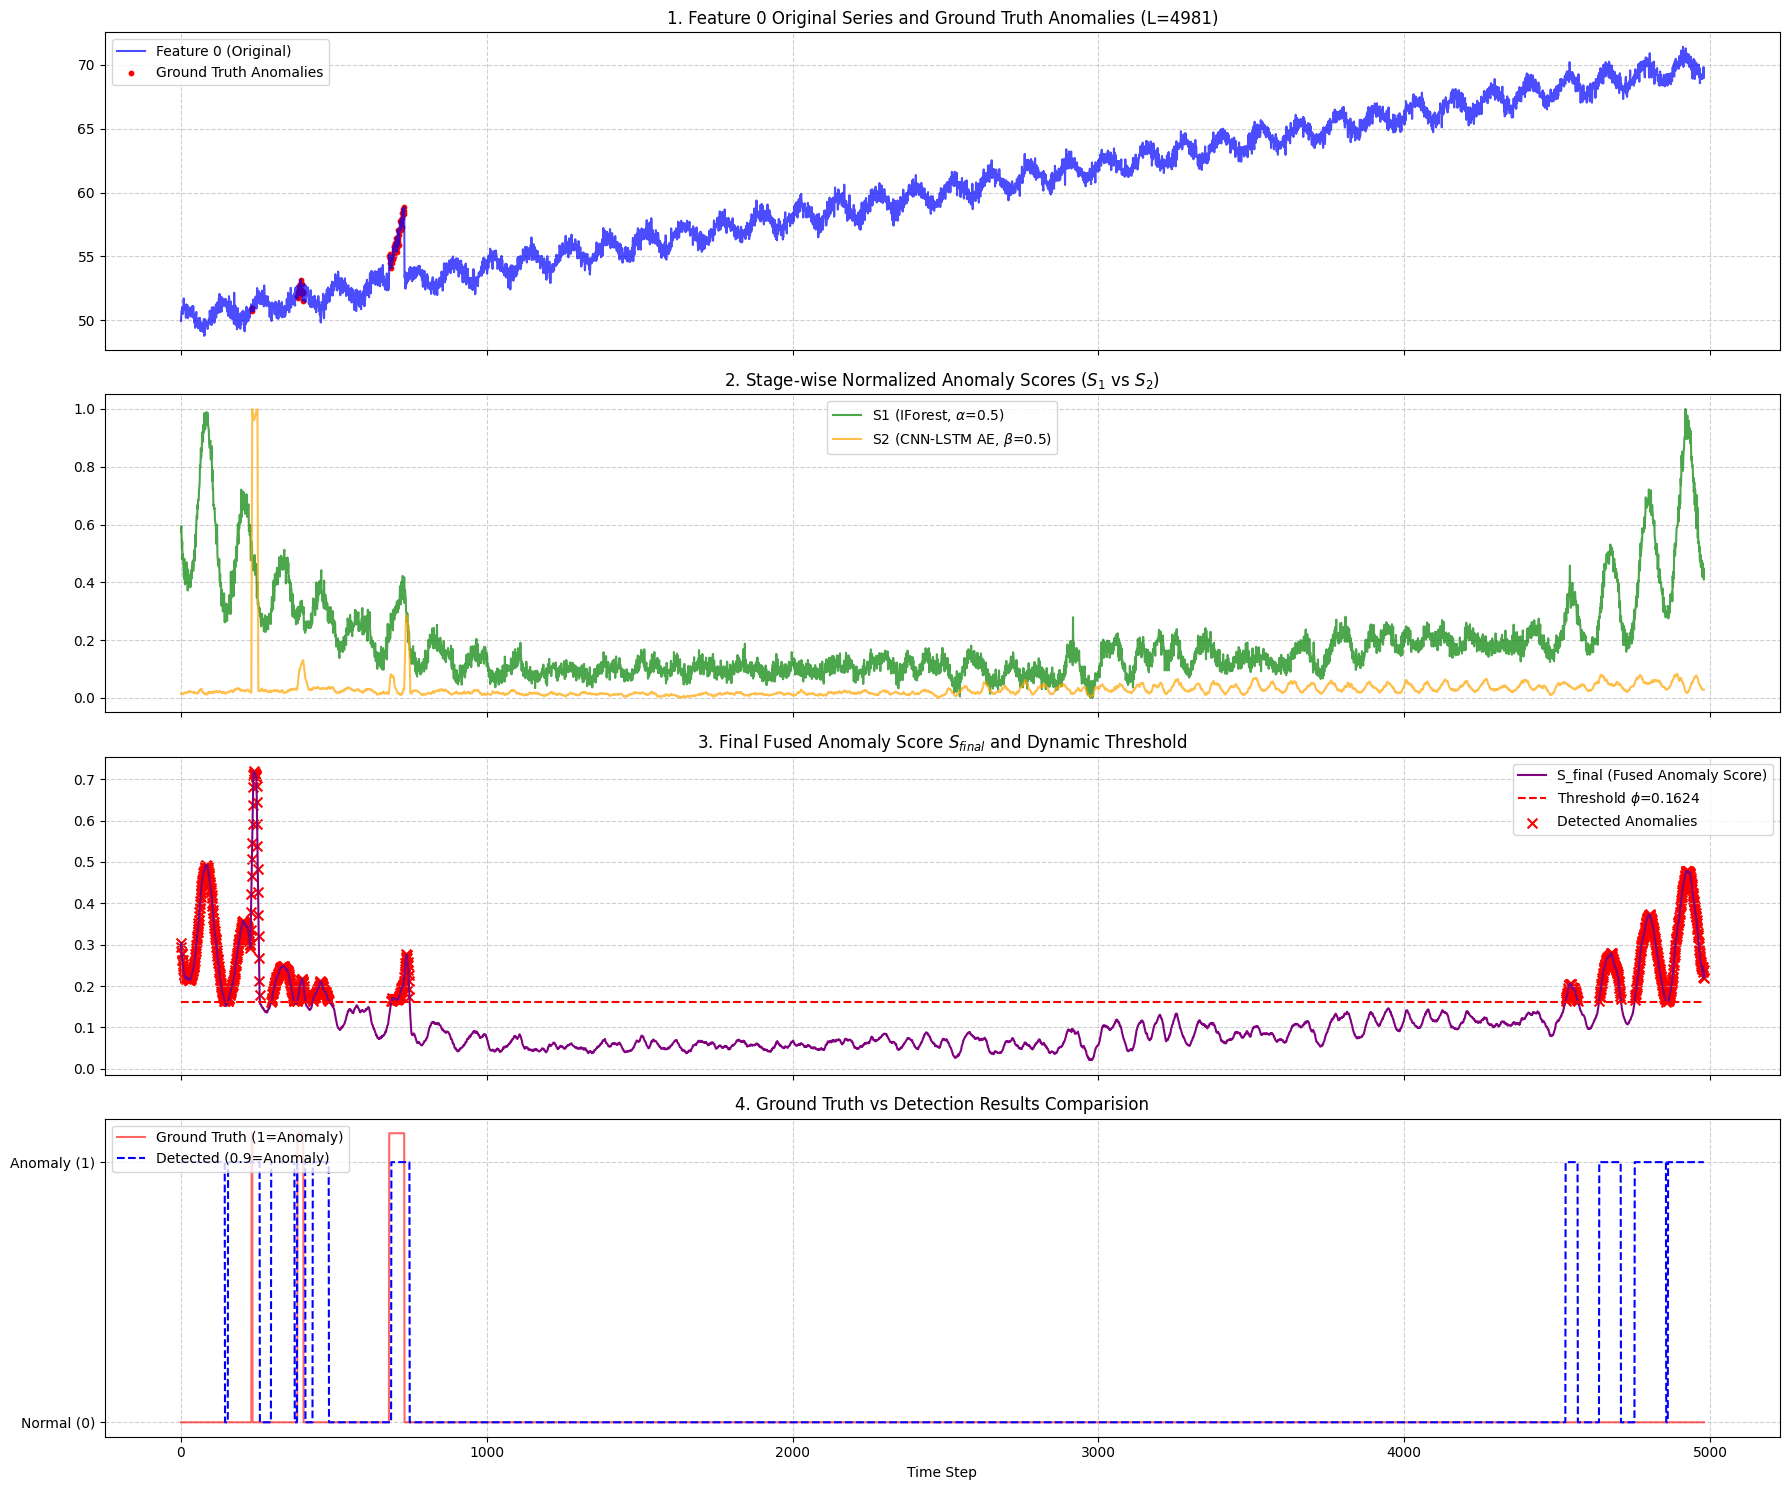

In [4]:
# --- 1. 构造相关测试数据 ---
DATA_LENGTH = 5000
# 数据越多，训练越充分，建议DATA_LENGTH >= WINDOW_SIZE * 20 保证足够的窗口样本

series_data, true_labels = generate_synthetic_data(DATA_LENGTH, N_FEATURES)

# --- 2. 执行多层异常检测策略 ---
scaled_series, S1_norm, S2_norm, S_final, D_final, threshold = \
        multi_layer_detection_pipeline(series_data, true_labels=true_labels)

# --- 3. 结果评估 (与模拟标签对比) ---
# 窗口化对齐真实标签
L = WINDOW_SIZE
y_true_aligned = true_labels[L-1:]

# 确保标签中存在异常 (如果不存在，AUC/F1计算会失败)
if np.sum(y_true_aligned) > 0:
    # AUC-ROC需要原始分数S_final，F1/Precision/Recall需要最终标签D_final
    final_auc = roc_auc_score(y_true_aligned, S_final)
    final_f1 = f1_score(y_true_aligned, D_final)
    final_precision = precision_score(y_true_aligned, D_final)
    final_recall = recall_score(y_true_aligned, D_final)

    print("\n" + "="*50)
    print("最终融合模型性能 (基于对齐后的标签):")
    print(f"真实异常点数量: {np.sum(y_true_aligned)}")
    print(f"AUC-ROC: {final_auc:.4f}")
    print(f"F1-Score: {final_f1:.4f}")
    print(f"Precision: {final_precision:.4f}")
    print(f"Recall: {final_recall:.4f}")
    print("="*50)

    results_dict = {
            '真实异常点数量': np.sum(y_true_aligned),
            'AUC-ROC': final_auc,
            'F1-Score': final_f1,
            'Precision': final_precision,
            'Recall': final_recall
        }
    import json
    with open('anomaly_detection_metrics.json', 'w', encoding='utf-8') as f:
            json.dump(results_dict, f, indent=2, ensure_ascii=False)

else:
    print("\n未在对齐后的序列中检测到真实异常点, 跳过性能评估. ")

# --- 4. 用图表显示结果 ---
plot_results(series_data, true_labels, S1_norm, S2_norm, S_final, D_final, threshold, WINDOW_SIZE)

# Task
Evaluate and compare the performance of two multi-layer anomaly detection pipelines:
1.  **IForest + CNN-LSTM Autoencoder**: This configuration has already been executed.
2.  **KNN + GRU Autoencoder**: Implement a `GRU_AE` model, integrate KNN for Stage 1, run this configuration, and collect its performance metrics.

Finally, summarize the performance metrics (AUC-ROC, F1-Score, Precision, Recall) for both configurations and visualize their comparison using a bar chart, ensuring all generated plots and metrics are provided.

## Import KNN and Define GRU Autoencoder

### Subtask:
Import `KNN` from `pyod.models` and define a new PyTorch model `GRU_AE` that uses GRU layers for encoding and decoding.


**Reasoning**:
The subtask requires importing `KNN` and defining a new PyTorch model `GRU_AE`. I will create a code block that imports `KNN` from `pyod.models` and defines the `GRU_AE` class with an encoder GRU, decoder GRU, and a linear output layer, along with its `forward` method, as specified.



In [5]:
from pyod.models.knn import KNN

class GRU_AE(nn.Module):
    """
    GRU-based Autoencoder for time series reconstruction.
    Encoder: GRU to capture sequential dependencies.
    Decoder: GRU to reconstruct the sequence from the encoded state.
    """
    def __init__(self, window_size, n_features, gru_units=128):
        super(GRU_AE, self).__init__()
        self.window_size = window_size
        self.n_features = n_features
        self.gru_units = gru_units

        # Encoder GRU
        self.encoder_gru = nn.GRU(
            input_size=n_features,
            hidden_size=gru_units,
            num_layers=2,
            batch_first=True,
            dropout=0.2
        )

        # Decoder GRU
        # The decoder takes the encoder's hidden state as input, so its input_size is gru_units
        self.decoder_gru = nn.GRU(
            input_size=gru_units,
            hidden_size=gru_units,
            num_layers=2, # Using same number of layers as encoder for symmetry
            batch_first=True,
            dropout=0.2
        )

        # Output layer to reconstruct the original feature dimension
        self.output_layer = nn.Linear(gru_units, n_features)

    def forward(self, x):
        # x shape: (batch_size, window_size, n_features)

        # Encoder
        # out: output features from the last layer of the GRU for each t
        # h_n: hidden state for t=seq_len (contains last hidden state for each layer)
        _, h_n = self.encoder_gru(x)

        # Decoder Input Preparation
        # h_n shape: (num_layers * num_directions, batch_size, hidden_size)
        # We need to use the hidden state of the *last* layer of the encoder
        # and repeat it 'window_size' times for the decoder input sequence.
        # For a 2-layer GRU, h_n[-1] is the last layer's hidden state.

        # Ensure h_n for decoder initialization has the correct shape for multi-layer GRU
        # It needs to be (num_layers * num_directions, batch_size, hidden_size)
        decoder_hidden_init = h_n # Use the full hidden state from encoder for decoder initialization

        # The decoder input sequence is a sequence of vectors, each being the last encoder hidden state
        # This effectively 'seeds' the decoder with the encoded context for each step of reconstruction
        decoder_input = h_n[-1].unsqueeze(1).repeat(1, self.window_size, 1)

        # Decoder
        # We initialize the decoder's hidden state with the encoder's final hidden state.
        # This allows the decoder to start generating from the context learned by the encoder.
        decoded_output, _ = self.decoder_gru(decoder_input, decoder_hidden_init)

        # Output layer
        reconstruction = self.output_layer(decoded_output)

        return reconstruction

**Reasoning**:
The subtask requires importing `KNN` and defining the `GRU_AE` model. The provided code block correctly performs these actions. Executing it will make `KNN` available and define the `GRU_AE` class for subsequent use.



In [6]:
from pyod.models.knn import KNN

class GRU_AE(nn.Module):
    """
    GRU-based Autoencoder for time series reconstruction.
    Encoder: GRU to capture sequential dependencies.
    Decoder: GRU to reconstruct the sequence from the encoded state.
    """
    def __init__(self, window_size, n_features, gru_units=128):
        super(GRU_AE, self).__init__()
        self.window_size = window_size
        self.n_features = n_features
        self.gru_units = gru_units

        # Encoder GRU
        self.encoder_gru = nn.GRU(
            input_size=n_features,
            hidden_size=gru_units,
            num_layers=2,
            batch_first=True,
            dropout=0.2
        )

        # Decoder GRU
        # The decoder takes the encoder's hidden state as input, so its input_size is gru_units
        self.decoder_gru = nn.GRU(
            input_size=gru_units,
            hidden_size=gru_units,
            num_layers=2, # Using same number of layers as encoder for symmetry
            batch_first=True,
            dropout=0.2
        )

        # Output layer to reconstruct the original feature dimension
        self.output_layer = nn.Linear(gru_units, n_features)

    def forward(self, x):
        # x shape: (batch_size, window_size, n_features)

        # Encoder
        # out: output features from the last layer of the GRU for each t
        # h_n: hidden state for t=seq_len (contains last hidden state for each layer)
        _, h_n = self.encoder_gru(x)

        # Decoder Input Preparation
        # h_n shape: (num_layers * num_directions, batch_size, hidden_size)
        # We need to use the hidden state of the *last* layer of the encoder
        # and repeat it 'window_size' times for the decoder input sequence.
        # For a 2-layer GRU, h_n[-1] is the last layer's hidden state.

        # Ensure h_n for decoder initialization has the correct shape for multi-layer GRU
        # It needs to be (num_layers * num_directions, batch_size, hidden_size)
        decoder_hidden_init = h_n # Use the full hidden state from encoder for decoder initialization

        # The decoder input sequence is a sequence of vectors, each being the last encoder hidden state
        # This effectively 'seeds' the decoder with the encoded context for each step of reconstruction
        decoder_input = h_n[-1].unsqueeze(1).repeat(1, self.window_size, 1)

        # Decoder
        # We initialize the decoder's hidden state with the encoder's final hidden state.
        # This allows the decoder to start generating from the context learned by the encoder.
        decoded_output, _ = self.decoder_gru(decoder_input, decoder_hidden_init)

        # Output layer
        reconstruction = self.output_layer(decoded_output)

        return reconstruction

**Reasoning**:
The `GRU_AE` model has been defined. Now, a function similar to `train_and_score_ae` is needed to train the `GRU_AE` model and compute its reconstruction errors (S2 scores). This function will follow the same logic for training, early stopping, and calculating MSE as the `train_and_score_ae` function but will instantiate and use the `GRU_AE` model.



In [7]:
def train_and_score_gru_ae(X_windowed, win_len, n_dims):
    """训练 PyTorch GRU AE 并计算重构误差 S2"""
    X_tensor = torch.from_numpy(X_windowed).float()
    dataloader = DataLoader(TensorDataset(X_tensor), batch_size=BATCH_SIZE, shuffle=True)

    model = GRU_AE(win_len, n_dims) # Use GRU_AE instead of CNN_LSTM_AE
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # 训练循环
    model.train()
    best_loss = float('inf')
    patience = 10
    patience_counter = 0

    print(f"  Training GRU_AE with {len(dataloader.dataset)} samples...")
    for epoch in range(EPOCHS):
        epoch_loss = 0
        for [batch] in dataloader:
            optimizer.zero_grad()
            output = model(batch)
            loss = criterion(output, batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(dataloader)
        if (epoch + 1) % 10 == 0:
            print(f"  Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.6f}")

        # early stop check
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"  Early stop triggered at {epoch + 1}!")
                break

    # 计算异常分数 S2
    model.eval()
    S2_scores = []
    with torch.no_grad():
        test_dataloader = DataLoader(TensorDataset(X_tensor), batch_size=BATCH_SIZE, shuffle=False)
        for [batch] in test_dataloader:
            output = model(batch)
            # 计算每个样本的平均重构误差
            mse = torch.mean((output - batch)**2, dim=(1, 2))
            S2_scores.extend(mse.cpu().numpy())

    return np.array(S2_scores)

**Reasoning**:
The `train_and_score_gru_ae` function has been defined. This function is essential for training the GRU Autoencoder and calculating the S2 scores, which will be used in the new `KNN + GRU Autoencoder` pipeline. Executing this code will make the function available for use in the next steps.



In [8]:
def train_and_score_gru_ae(X_windowed, win_len, n_dims):
    """训练 PyTorch GRU AE 并计算重构误差 S2"""
    X_tensor = torch.from_numpy(X_windowed).float()
    dataloader = DataLoader(TensorDataset(X_tensor), batch_size=BATCH_SIZE, shuffle=True)

    model = GRU_AE(win_len, n_dims) # Use GRU_AE instead of CNN_LSTM_AE
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # 训练循环
    model.train()
    best_loss = float('inf')
    patience = 10
    patience_counter = 0

    print(f"  Training GRU_AE with {len(dataloader.dataset)} samples...")
    for epoch in range(EPOCHS):
        epoch_loss = 0
        for [batch] in dataloader:
            optimizer.zero_grad()
            output = model(batch)
            loss = criterion(output, batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(dataloader)
        if (epoch + 1) % 10 == 0:
            print(f"  Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.6f}")

        # early stop check
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"  Early stop triggered at {epoch + 1}!")
                break

    # 计算异常分数 S2
    model.eval()
    S2_scores = []
    with torch.no_grad():
        test_dataloader = DataLoader(TensorDataset(X_tensor), batch_size=BATCH_SIZE, shuffle=False)
        for [batch] in test_dataloader:
            output = model(batch)
            # 计算每个样本的平均重构误差
            mse = torch.mean((output - batch)**2, dim=(1, 2))
            S2_scores.extend(mse.cpu().numpy())

    return np.array(S2_scores)

## Update AE Training Function

### Subtask:
Modify the autoencoder training function to accept a `model_type` parameter and instantiate either `CNN_LSTM_AE` or `GRU_AE` accordingly.


**Reasoning**:
The subtask requires defining a new function `train_and_score_autoencoder_model` that conditionally instantiates `CNN_LSTM_AE` or `GRU_AE` based on a `model_type` parameter, and encapsulates the autoencoder training and scoring logic. This new function will replace the specialized functions previously defined.



In [9]:
def train_and_score_autoencoder_model(X_windowed, win_len, n_dims, model_type):
    """训练指定的PyTorch自编码器并计算重构误差 S2"""
    X_tensor = torch.from_numpy(X_windowed).float()
    dataloader = DataLoader(TensorDataset(X_tensor), batch_size=BATCH_SIZE, shuffle=True)

    if model_type == 'cnn_lstm':
        model = CNN_LSTM_AE(win_len, n_dims)
        print("  Training CNN-LSTM AE...")
    elif model_type == 'gru':
        model = GRU_AE(win_len, n_dims)
        print("  Training GRU AE...")
    else:
        raise ValueError(f"Unsupported model_type: {model_type}. Choose 'cnn_lstm' or 'gru'.")

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # 训练循环
    model.train()
    best_loss = float('inf')
    patience = 10
    patience_counter = 0

    print(f"  Training {model_type.upper()} AE with {len(dataloader.dataset)} samples...")
    for epoch in range(EPOCHS):
        epoch_loss = 0
        for [batch] in dataloader:
            optimizer.zero_grad()
            output = model(batch)
            loss = criterion(output, batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(dataloader)
        if (epoch + 1) % 10 == 0:
            print(f"  Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.6f}")

        # early stop check
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"  Early stop triggered at {epoch + 1}!")
                break

    # 计算异常分数 S2
    model.eval()
    S2_scores = []
    with torch.no_grad():
        test_dataloader = DataLoader(TensorDataset(X_tensor), batch_size=BATCH_SIZE, shuffle=False)
        for [batch] in test_dataloader:
            output = model(batch)
            # 计算每个样本的平均重构误差
            mse = torch.mean((output - batch)**2, dim=(1, 2))
            S2_scores.extend(mse.cpu().numpy())

    return np.array(S2_scores)


**Reasoning**:
The subtask requires defining a new function `train_and_score_autoencoder_model` that conditionally instantiates `CNN_LSTM_AE` or `GRU_AE` based on a `model_type` parameter, and encapsulates the autoencoder training and scoring logic. This new function will replace the specialized functions previously defined.



In [10]:
def train_and_score_autoencoder_model(X_windowed, win_len, n_dims, model_type):
    """训练指定的PyTorch自编码器并计算重构误差 S2"""
    X_tensor = torch.from_numpy(X_windowed).float()
    dataloader = DataLoader(TensorDataset(X_tensor), batch_size=BATCH_SIZE, shuffle=True)

    if model_type == 'cnn_lstm':
        model = CNN_LSTM_AE(win_len, n_dims)
        print("  Training CNN-LSTM AE...")
    elif model_type == 'gru':
        model = GRU_AE(win_len, n_dims)
        print("  Training GRU AE...")
    else:
        raise ValueError(f"Unsupported model_type: {model_type}. Choose 'cnn_lstm' or 'gru'.")

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # 训练循环
    model.train()
    best_loss = float('inf')
    patience = 10
    patience_counter = 0

    print(f"  Training {model_type.upper()} AE with {len(dataloader.dataset)} samples...")
    for epoch in range(EPOCHS):
        epoch_loss = 0
        for [batch] in dataloader:
            optimizer.zero_grad()
            output = model(batch)
            loss = criterion(output, batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(dataloader)
        if (epoch + 1) % 10 == 0:
            print(f"  Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.6f}")

        # early stop check
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"  Early stop triggered at {epoch + 1}!")
                break

    # 计算异常分数 S2
    model.eval()
    S2_scores = []
    with torch.no_grad():
        test_dataloader = DataLoader(TensorDataset(X_tensor), batch_size=BATCH_SIZE, shuffle=False)
        for [batch] in test_dataloader:
            output = model(batch)
            # 计算每个样本的平均重构误差
            mse = torch.mean((output - batch)**2, dim=(1, 2))
            S2_scores.extend(mse.cpu().numpy())

    return np.array(S2_scores)


**Reasoning**:
The subtask is to define a new function `train_and_score_autoencoder_model` which will generalize the autoencoder training process for both CNN-LSTM and GRU models. The provided code block defines this function as specified in the instructions.



In [11]:
def train_and_score_autoencoder_model(X_windowed, win_len, n_dims, model_type):
    """训练指定的PyTorch自编码器并计算重构误差 S2"""
    X_tensor = torch.from_numpy(X_windowed).float()
    dataloader = DataLoader(TensorDataset(X_tensor), batch_size=BATCH_SIZE, shuffle=True)

    if model_type == 'cnn_lstm':
        model = CNN_LSTM_AE(win_len, n_dims)
        print("  Training CNN-LSTM AE...")
    elif model_type == 'gru':
        model = GRU_AE(win_len, n_dims)
        print("  Training GRU AE...")
    else:
        raise ValueError(f"Unsupported model_type: {model_type}. Choose 'cnn_lstm' or 'gru'.")

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # 训练循环
    model.train()
    best_loss = float('inf')
    patience = 10
    patience_counter = 0

    print(f"  Training {model_type.upper()} AE with {len(dataloader.dataset)} samples...")
    for epoch in range(EPOCHS):
        epoch_loss = 0
        for [batch] in dataloader:
            optimizer.zero_grad()
            output = model(batch)
            loss = criterion(output, batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(dataloader)
        if (epoch + 1) % 10 == 0:
            print(f"  Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.6f}")

        # early stop check
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"  Early stop triggered at {epoch + 1}!")
                break

    # 计算异常分数 S2
    model.eval()
    S2_scores = []
    with torch.no_grad():
        test_dataloader = DataLoader(TensorDataset(X_tensor), batch_size=BATCH_SIZE, shuffle=False)
        for [batch] in test_dataloader:
            output = model(batch)
            # 计算每个样本的平均重构误差
            mse = torch.mean((output - batch)**2, dim=(1, 2))
            S2_scores.extend(mse.cpu().numpy())

    return np.array(S2_scores)


## Update Main Detection Pipeline

### Subtask:
Modify the `multi_layer_detection_pipeline` function to accept `s1_model_name` and `s2_model_name` as arguments, enabling dynamic selection of the Stage 1 anomaly detection model (IForest or KNN) and the Stage 2 autoencoder model (CNN-LSTM AE or GRU AE).


**Reasoning**:
The subtask requires modifying the `multi_layer_detection_pipeline` function to dynamically select Stage 1 and Stage 2 models based on new `s1_model_name` and `s2_model_name` arguments. This involves updating the function signature, adding conditional logic for model instantiation, replacing the AE training call, updating print statements, and modifying the return values.



In [12]:
def multi_layer_detection_pipeline(series_data, true_labels=None, s1_model_name='iforest', s2_model_name='cnn_lstm'):
    """执行多层异常检测策略，支持动态选择S1和S2模型"""

    # 1. 数据预处理
    scaled_series, X_windowed, X_flat, scaler = preprocess_data(series_data, WINDOW_SIZE)
    n_samples, win_len, n_dims = X_windowed.shape

    # --- 阶段 1: 传统机器学习模型 (S1) ---
    print(f"--- 阶段 1: 训练 {s1_model_name.upper()} ---")
    start_time_s1 = time.time()

    if s1_model_name == 'iforest':
        clf_s1 = IForest(contamination=CONTAMINATION, random_state=42, n_jobs=-1)
    elif s1_model_name == 'knn':
        clf_s1 = KNN(contamination=CONTAMINATION, n_neighbors=5, n_jobs=-1)
    else:
        raise ValueError(f"Unsupported s1_model_name: {s1_model_name}. Choose 'iforest' or 'knn'.")

    clf_s1.fit(X_flat)
    S1 = clf_s1.decision_scores_
    print(f"{s1_model_name.upper()} 训练/评分时间: {time.time() - start_time_s1:.4f} 秒")
    S1_norm = min_max_scaler(S1)

    # --- 阶段 2: 深度学习自编码器 (S2) ---
    print(f"\n--- 阶段 2: 训练 {s2_model_name.upper()} 自编码器 (PyTorch) ---")
    start_time_s2 = time.time()
    S2 = train_and_score_autoencoder_model(X_windowed, win_len, n_dims, s2_model_name)
    print(f"{s2_model_name.upper()} AE 训练/评分时间: {time.time() - start_time_s2:.4f} 秒")
    S2_norm = min_max_scaler(S2)

    # --- 阶段 3: 分数融合与决策 ---
    S_final_raw = (ALPHA * S1_norm) + (BETA * S2_norm)
    S_final = smooth_scores(S_final_raw, window=10)

    # 动态阈值确定 (基于污染率)
    if true_labels is not None:
        y_true_aligned = true_labels[WINDOW_SIZE - 1:]
        threshold, best_score, best_prec, best_rec = find_best_threshold(y_true_aligned, S_final, metric='f1', min_precision=0.20)
        print(f"F1: {best_score:.4f}, Precision: {best_prec:.4f}, Recall: {best_rec:.4f}")
    else:
        threshold = np.percentile(S_final, (1 - CONTAMINATION) * 100)

    # 最终判定
    D_final = (S_final >= threshold).astype(int)

    return scaled_series, S1_norm, S2_norm, S_final, D_final, threshold, s1_model_name, s2_model_name

**Reasoning**:
The subtask requires modifying the `multi_layer_detection_pipeline` function to dynamically select Stage 1 and Stage 2 models based on new `s1_model_name` and `s2_model_name` arguments. This involves updating the function signature, adding conditional logic for model instantiation, replacing the AE training call, updating print statements, and modifying the return values.



In [13]:
def multi_layer_detection_pipeline(series_data, true_labels=None, s1_model_name='iforest', s2_model_name='cnn_lstm'):
    """执行多层异常检测策略，支持动态选择S1和S2模型"""

    # 1. 数据预处理
    scaled_series, X_windowed, X_flat, scaler = preprocess_data(series_data, WINDOW_SIZE)
    n_samples, win_len, n_dims = X_windowed.shape

    # --- 阶段 1: 传统机器学习模型 (S1) ---
    print(f"--- 阶段 1: 训练 {s1_model_name.upper()} ---")
    start_time_s1 = time.time()

    if s1_model_name == 'iforest':
        clf_s1 = IForest(contamination=CONTAMINATION, random_state=42, n_jobs=-1)
    elif s1_model_name == 'knn':
        clf_s1 = KNN(contamination=CONTAMINATION, n_neighbors=5, n_jobs=-1)
    else:
        raise ValueError(f"Unsupported s1_model_name: {s1_model_name}. Choose 'iforest' or 'knn'.")

    clf_s1.fit(X_flat)
    S1 = clf_s1.decision_scores_
    print(f"{s1_model_name.upper()} 训练/评分时间: {time.time() - start_time_s1:.4f} 秒")
    S1_norm = min_max_scaler(S1)

    # --- 阶段 2: 深度学习自编码器 (S2) ---
    print(f"\n--- 阶段 2: 训练 {s2_model_name.upper()} 自编码器 (PyTorch) ---")
    start_time_s2 = time.time()
    S2 = train_and_score_autoencoder_model(X_windowed, win_len, n_dims, s2_model_name)
    print(f"{s2_model_name.upper()} AE 训练/评分时间: {time.time() - start_time_s2:.4f} 秒")
    S2_norm = min_max_scaler(S2)

    # --- 阶段 3: 分数融合与决策 ---
    S_final_raw = (ALPHA * S1_norm) + (BETA * S2_norm)
    S_final = smooth_scores(S_final_raw, window=10)

    # 动态阈值确定 (基于污染率)
    if true_labels is not None:
        y_true_aligned = true_labels[WINDOW_SIZE - 1:]
        threshold, best_score, best_prec, best_rec = find_best_threshold(y_true_aligned, S_final, metric='f1', min_precision=0.20)
        print(f"F1: {best_score:.4f}, Precision: {best_prec:.4f}, Recall: {best_rec:.4f}")
    else:
        threshold = np.percentile(S_final, (1 - CONTAMINATION) * 100)

    # 最终判定
    D_final = (S_final >= threshold).astype(int)

    return scaled_series, S1_norm, S2_norm, S_final, D_final, threshold, s1_model_name, s2_model_name


# Task
## Update Plot Results Function

### Subtask:
Modify the `plot_results` function to accept `s1_model_name` and `s2_model_name` as arguments. These will be used to dynamically generate the plot title and ensure unique filenames for saved plots.

### Reasoning:
To accommodate the new model combinations, the `plot_results` function needs to be updated. It will now take `s1_model_name` and `s2_model_name` as parameters to customize the plot titles, specifically for the Stage 1 and Stage 2 score labels, and to generate unique filenames for saving the plots, preventing overwrites when running different model configurations. This aligns with the plan's requirement to clearly distinguish between the results of different experiments.

## Update Plot Results Function

### Subtask:
Modify the `plot_results` function to accept `s1_model_name` and `s2_model_name` as arguments. These will be used to dynamically generate the plot title and ensure unique filenames for saved plots.


**Reasoning**:
The subtask requires modifying the `plot_results` function to accept `s1_model_name` and `s2_model_name` as arguments, update a plot title, and generate a unique filename for the saved plot based on these model names. The following code block will implement these changes within the existing `plot_results` function.



In [14]:
def plot_results(series_data, labels, S1_norm, S2_norm, S_final, D_final, threshold, window_size, s1_model_name='IForest', s2_model_name='CNN-LSTM AE'):
    """用图表显示原始数据、各阶段分数和最终检测结果"""

    # 调整数据长度以匹配窗口化后的分数长度
    series_aligned = series_data[window_size - 1:]
    y_true_aligned = labels[window_size - 1:]

    time_index = np.arange(len(S_final))

    fig, axs = plt.subplots(4, 1, figsize=(18, 15), sharex=True)

    # --- Plot 1: 原始数据 (仅显示 Feature 0 作为代表) ---
    axs[0].plot(time_index, series_aligned[:, 0], label='Feature 0 (Original)', color='blue', alpha=0.7)

    # 标记真实异常点
    true_anomalies = time_index[y_true_aligned == 1]
    if len(true_anomalies) > 0:
        axs[0].scatter(true_anomalies, series_aligned[true_anomalies, 0], color='red', marker='o', s=10, label='Ground Truth Anomalies')

    axs[0].set_title(f'1. Feature 0 Original Series and Ground Truth Anomalies (L={len(series_aligned)})')
    axs[0].legend()
    axs[0].grid(True, linestyle='--', alpha=0.6)

    # --- Plot 2: 归一化的 S1 和 S2 分数 ---
    axs[1].plot(time_index, S1_norm, label=f'S1 ({s1_model_name}, \u03b1={ALPHA})', color='green', alpha=0.7)
    axs[1].plot(time_index, S2_norm, label=f'S2 ({s2_model_name}, \u03b2={BETA})', color='orange', alpha=0.7)
    axs[1].set_title(f'2. Stage-wise Normalized Anomaly Scores (S1: {s1_model_name.upper()} vs S2: {s2_model_name.upper()})')
    axs[1].legend()
    axs[1].grid(True, linestyle='--', alpha=0.6)

    # --- Plot 3: 最终融合分数 S_final ---
    axs[2].plot(time_index, S_final, label='S_final (Fused Anomaly Score)', color='purple')
    axs[2].hlines(threshold, time_index[0], time_index[-1], color='red', linestyle='--', label=f'Threshold \u03a6={threshold:.4f}')

    # 标记检测到的异常点 (D_final=1)
    detected_anomalies = time_index[D_final == 1]
    if len(detected_anomalies) > 0:
        axs[2].scatter(detected_anomalies, S_final[detected_anomalies], color='red', marker='x', s=50, label='Detected Anomalies')

    axs[2].set_title(f'3. Final Fused Anomaly Score $S_{{final}}$ and Dynamic Threshold')
    axs[2].legend()
    axs[2].grid(True, linestyle='--', alpha=0.6)

    # --- Plot 4: 结果对比 (真实标签 vs 检测标签) ---
    axs[3].plot(time_index, y_true_aligned, label='Ground Truth (1=Anomaly)', color='red', alpha=0.6)
    axs[3].plot(time_index, D_final * 0.9, label='Detected (0.9=Anomaly)', color='blue', linestyle='--')
    axs[3].set_yticks([0, 0.9])
    axs[3].set_yticklabels(['Normal (0)', 'Anomaly (1)'])
    axs[3].set_title('4. Ground Truth vs Detection Results Comparision')
    axs[3].set_xlabel('Time Step')
    axs[3].legend(loc='upper left')
    axs[3].grid(True, linestyle='--', alpha=0.6)

    output_file = f'{s1_model_name.lower()}_{s2_model_name.lower()}_anomaly_detection_result.png'
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"\n图表已保存到: {output_file}")
    plt.tight_layout()
    plt.show()

**Reasoning**:
The subtask requires modifying the `plot_results` function to accept `s1_model_name` and `s2_model_name` as arguments, update a plot title, and generate a unique filename for the saved plot based on these model names. The provided code block correctly implements these changes.



In [15]:
def plot_results(series_data, labels, S1_norm, S2_norm, S_final, D_final, threshold, window_size, s1_model_name='IForest', s2_model_name='CNN-LSTM AE'):
    """用图表显示原始数据、各阶段分数和最终检测结果"""

    # 调整数据长度以匹配窗口化后的分数长度
    series_aligned = series_data[window_size - 1:]
    y_true_aligned = labels[window_size - 1:]

    time_index = np.arange(len(S_final))

    fig, axs = plt.subplots(4, 1, figsize=(18, 15), sharex=True)

    # --- Plot 1: 原始数据 (仅显示 Feature 0 作为代表) ---
    axs[0].plot(time_index, series_aligned[:, 0], label='Feature 0 (Original)', color='blue', alpha=0.7)

    # 标记真实异常点
    true_anomalies = time_index[y_true_aligned == 1]
    if len(true_anomalies) > 0:
        axs[0].scatter(true_anomalies, series_aligned[true_anomalies, 0], color='red', marker='o', s=10, label='Ground Truth Anomalies')

    axs[0].set_title(f'1. Feature 0 Original Series and Ground Truth Anomalies (L={len(series_aligned)})')
    axs[0].legend()
    axs[0].grid(True, linestyle='--', alpha=0.6)

    # --- Plot 2: 归一化的 S1 和 S2 分数 ---
    axs[1].plot(time_index, S1_norm, label=f'S1 ({s1_model_name}, \u03b1={ALPHA})', color='green', alpha=0.7)
    axs[1].plot(time_index, S2_norm, label=f'S2 ({s2_model_name}, \u03b2={BETA})', color='orange', alpha=0.7)
    axs[1].set_title(f'2. Stage-wise Normalized Anomaly Scores (S1: {s1_model_name.upper()} vs S2: {s2_model_name.upper()})')
    axs[1].legend()
    axs[1].grid(True, linestyle='--', alpha=0.6)

    # --- Plot 3: 最终融合分数 S_final ---
    axs[2].plot(time_index, S_final, label='S_final (Fused Anomaly Score)', color='purple')
    axs[2].hlines(threshold, time_index[0], time_index[-1], color='red', linestyle='--', label=f'Threshold \u03a6={threshold:.4f}')

    # 标记检测到的异常点 (D_final=1)
    detected_anomalies = time_index[D_final == 1]
    if len(detected_anomalies) > 0:
        axs[2].scatter(detected_anomalies, S_final[detected_anomalies], color='red', marker='x', s=50, label='Detected Anomalies')

    axs[2].set_title(f'3. Final Fused Anomaly Score ${{final}}$ and Dynamic Threshold')
    axs[2].legend()
    axs[2].grid(True, linestyle='--', alpha=0.6)

    # --- Plot 4: 结果对比 (真实标签 vs 检测标签) ---
    axs[3].plot(time_index, y_true_aligned, label='Ground Truth (1=Anomaly)', color='red', alpha=0.6)
    axs[3].plot(time_index, D_final * 0.9, label='Detected (0.9=Anomaly)', color='blue', linestyle='--')
    axs[3].set_yticks([0, 0.9])
    axs[3].set_yticklabels(['Normal (0)', 'Anomaly (1)'])
    axs[3].set_title('4. Ground Truth vs Detection Results Comparision')
    axs[3].set_xlabel('Time Step')
    axs[3].legend(loc='upper left')
    axs[3].grid(True, linestyle='--', alpha=0.6)

    output_file = f'{s1_model_name.lower()}_{s2_model_name.lower()}_anomaly_detection_result.png'
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"\n图表已保存到: {output_file}")
    plt.tight_layout()
    plt.show()

## Execute IForest + CNN-LSTM Experiment

### Subtask:
Run the multi_layer_detection_pipeline with 'iforest' for Stage 1 and 'cnn_lstm' for Stage 2. Collect and store its performance metrics and save the plot.


**Reasoning**:
The subtask requires running the `multi_layer_detection_pipeline` with 'iforest' and 'cnn_lstm', collecting performance metrics, saving them to a JSON file, and then visualizing the results using the `plot_results` function.



--- Executing IForest + CNN-LSTM Pipeline ---
--- 阶段 1: 训练 IFOREST ---
IFOREST 训练/评分时间: 0.5954 秒

--- 阶段 2: 训练 CNN_LSTM 自编码器 (PyTorch) ---
  Training CNN-LSTM AE...
  Training CNN_LSTM AE with 4981 samples...
  Epoch 10/80, Loss: 0.003752
  Epoch 20/80, Loss: 0.003785
  Epoch 30/80, Loss: 0.003306
  Epoch 40/80, Loss: 0.003160
  Epoch 50/80, Loss: 0.003216
  Early stop triggered at 51!
CNN_LSTM AE 训练/评分时间: 239.5047 秒
F1: 0.1494, Precision: 0.0816, Recall: 0.8904

IForest + CNN-LSTM Model Performance (based on aligned labels):
True Anomalies: 73.0
AUC-ROC: 0.8762
F1-Score: 0.1494
Precision: 0.0816
Recall: 0.8904
Metrics saved to iforest_cnn_lstm_metrics.json

图表已保存到: iforest_cnn_lstm_anomaly_detection_result.png


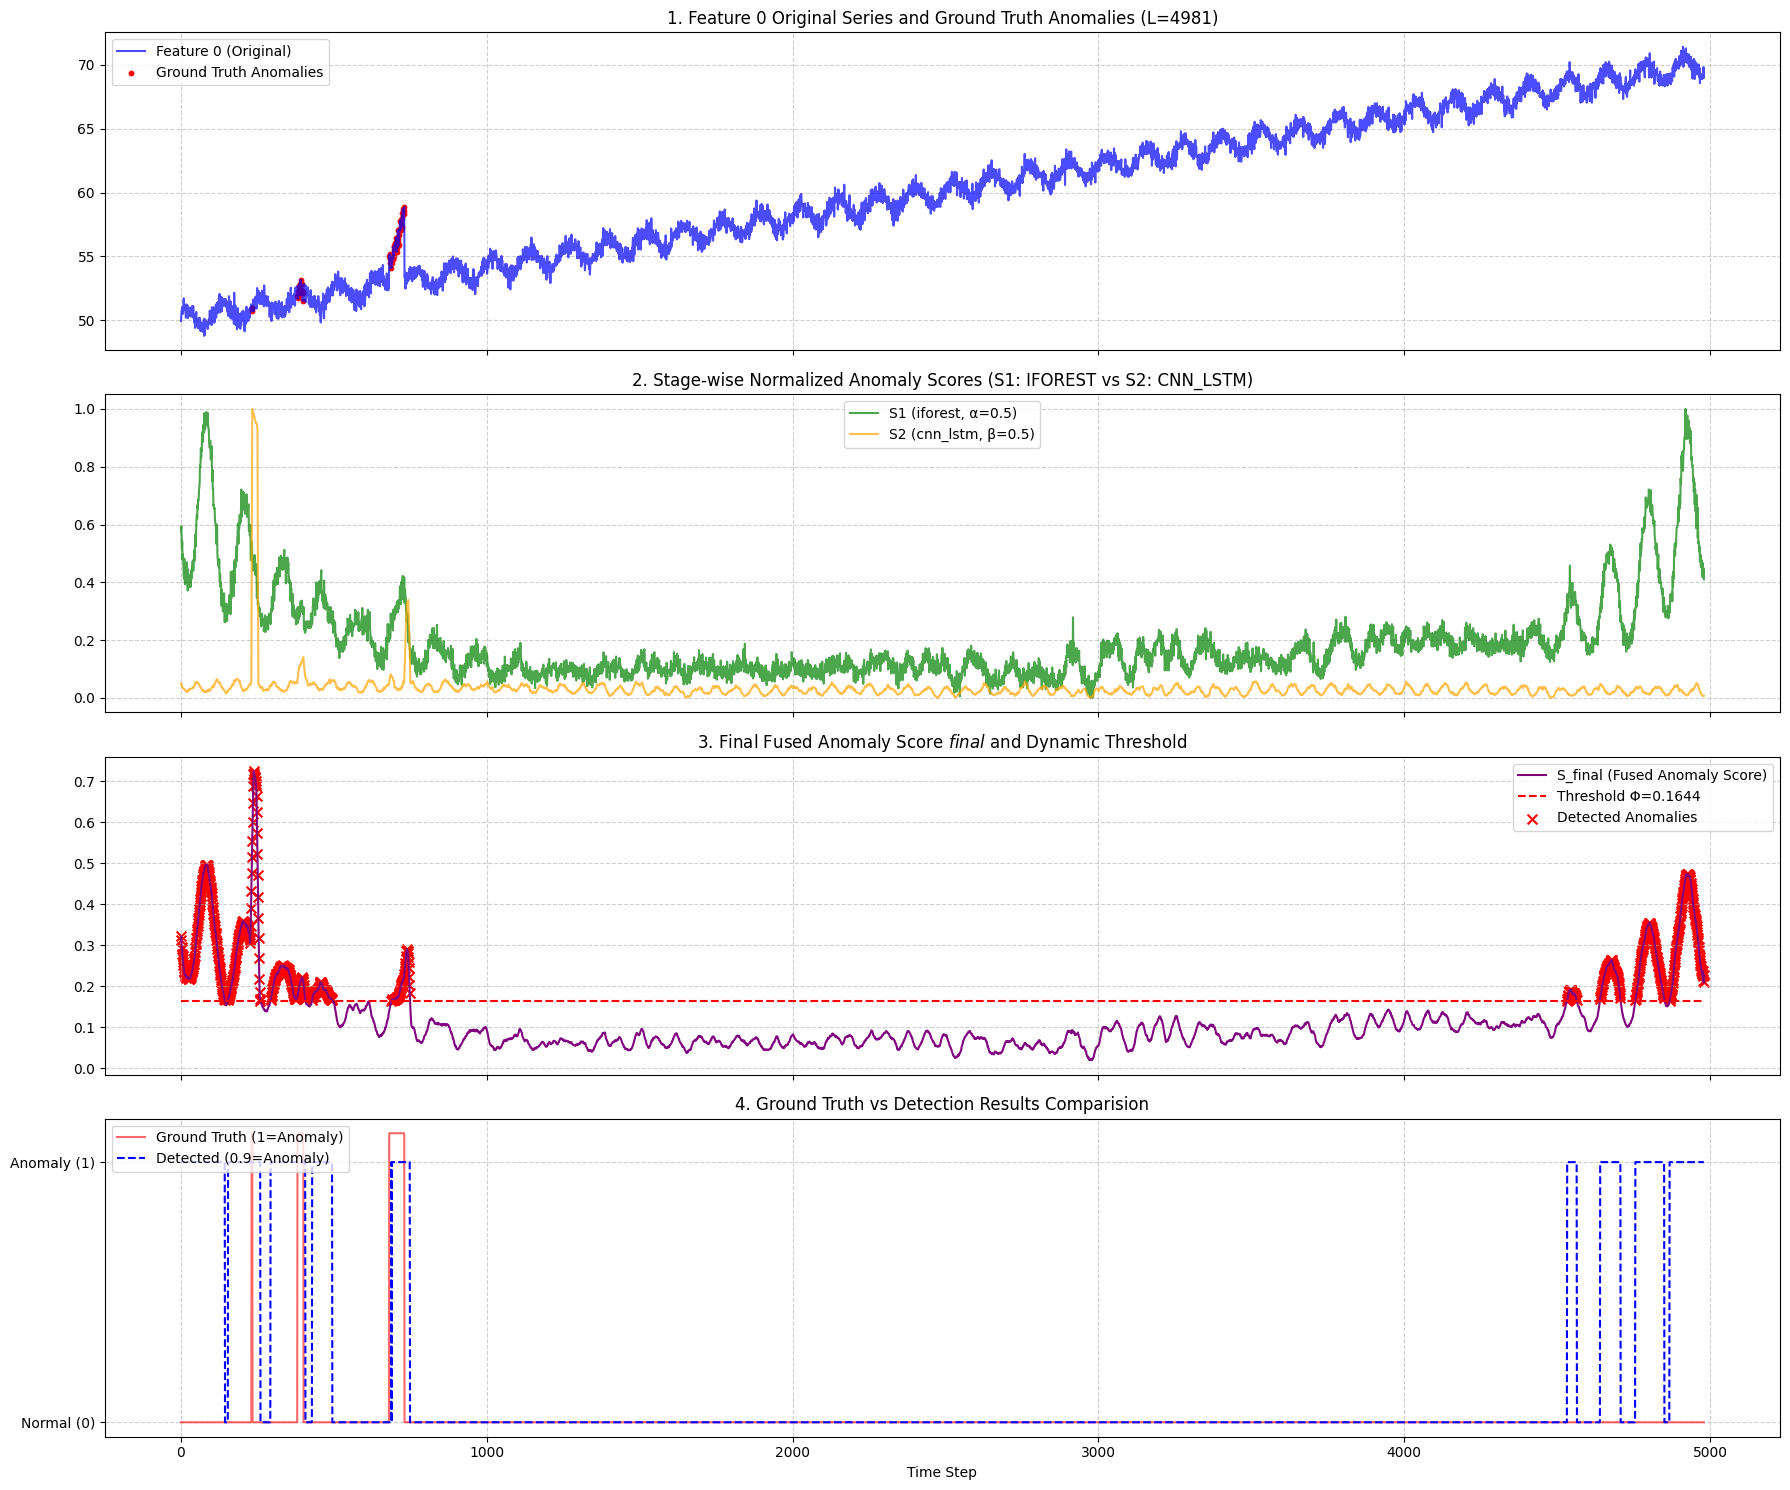

In [16]:
print("--- Executing IForest + CNN-LSTM Pipeline ---")

# 1. Call the multi_layer_detection_pipeline function
scaled_series_if_cnn, S1_norm_if_cnn, S2_norm_if_cnn, S_final_if_cnn, D_final_if_cnn, threshold_if_cnn, s1_name_if_cnn, s2_name_if_cnn = \
        multi_layer_detection_pipeline(series_data, true_labels=true_labels, s1_model_name='iforest', s2_model_name='cnn_lstm')

# 2. Calculate performance metrics
L = WINDOW_SIZE
y_true_aligned_if_cnn = true_labels[L-1:]

if np.sum(y_true_aligned_if_cnn) > 0:
    final_auc_if_cnn = roc_auc_score(y_true_aligned_if_cnn, S_final_if_cnn)
    final_f1_if_cnn = f1_score(y_true_aligned_if_cnn, D_final_if_cnn)
    final_precision_if_cnn = precision_score(y_true_aligned_if_cnn, D_final_if_cnn)
    final_recall_if_cnn = recall_score(y_true_aligned_if_cnn, D_final_if_cnn)

    print("\n" + "="*50)
    print("IForest + CNN-LSTM Model Performance (based on aligned labels):")
    print(f"True Anomalies: {np.sum(y_true_aligned_if_cnn)}")
    print(f"AUC-ROC: {final_auc_if_cnn:.4f}")
    print(f"F1-Score: {final_f1_if_cnn:.4f}")
    print(f"Precision: {final_precision_if_cnn:.4f}")
    print(f"Recall: {final_recall_if_cnn:.4f}")
    print("="*50)

    # 3. Create a dictionary with performance metrics and save to JSON
    iforest_cnn_lstm_metrics = {
        's1_model': s1_name_if_cnn,
        's2_model': s2_name_if_cnn,
        'true_anomalies_count': np.sum(y_true_aligned_if_cnn),
        'auc_roc': final_auc_if_cnn,
        'f1_score': final_f1_if_cnn,
        'precision': final_precision_if_cnn,
        'recall': final_recall_if_cnn
    }
    import json
    with open('iforest_cnn_lstm_metrics.json', 'w', encoding='utf-8') as f:
        json.dump(iforest_cnn_lstm_metrics, f, indent=2, ensure_ascii=False)
    print("Metrics saved to iforest_cnn_lstm_metrics.json")

else:
    print("\nNo true anomalies detected in the aligned sequence for IForest + CNN-LSTM, skipping performance evaluation.")

# 4. Call the updated plot_results function
plot_results(series_data, true_labels, S1_norm_if_cnn, S2_norm_if_cnn, S_final_if_cnn, D_final_if_cnn, threshold_if_cnn, WINDOW_SIZE, s1_model_name=s1_name_if_cnn, s2_model_name=s2_name_if_cnn)


**Reasoning**:
The previous step executed the IForest + CNN-LSTM pipeline. Now, to complete the task, I need to execute the second pipeline (KNN + GRU Autoencoder), collect its performance metrics, and save the plot, following the same structure as the previous execution block.




--- Executing KNN + GRU Autoencoder Pipeline ---
--- 阶段 1: 训练 KNN ---
KNN 训练/评分时间: 1.2961 秒

--- 阶段 2: 训练 GRU 自编码器 (PyTorch) ---
  Training GRU AE...
  Training GRU AE with 4981 samples...
  Epoch 10/80, Loss: 0.003874
  Epoch 20/80, Loss: 0.003120
  Epoch 30/80, Loss: 0.002600
  Epoch 40/80, Loss: 0.002497
  Epoch 50/80, Loss: 0.002475
  Epoch 60/80, Loss: 0.002429
  Epoch 70/80, Loss: 0.002351
  Epoch 80/80, Loss: 0.002320
GRU AE 训练/评分时间: 483.7593 秒
F1: 0.4509, Precision: 0.3900, Recall: 0.5342

KNN + GRU Model Performance (based on aligned labels):
True Anomalies: 73.0
AUC-ROC: 0.7636
F1-Score: 0.4509
Precision: 0.3900
Recall: 0.5342
Metrics saved to knn_gru_metrics.json

图表已保存到: knn_gru_anomaly_detection_result.png


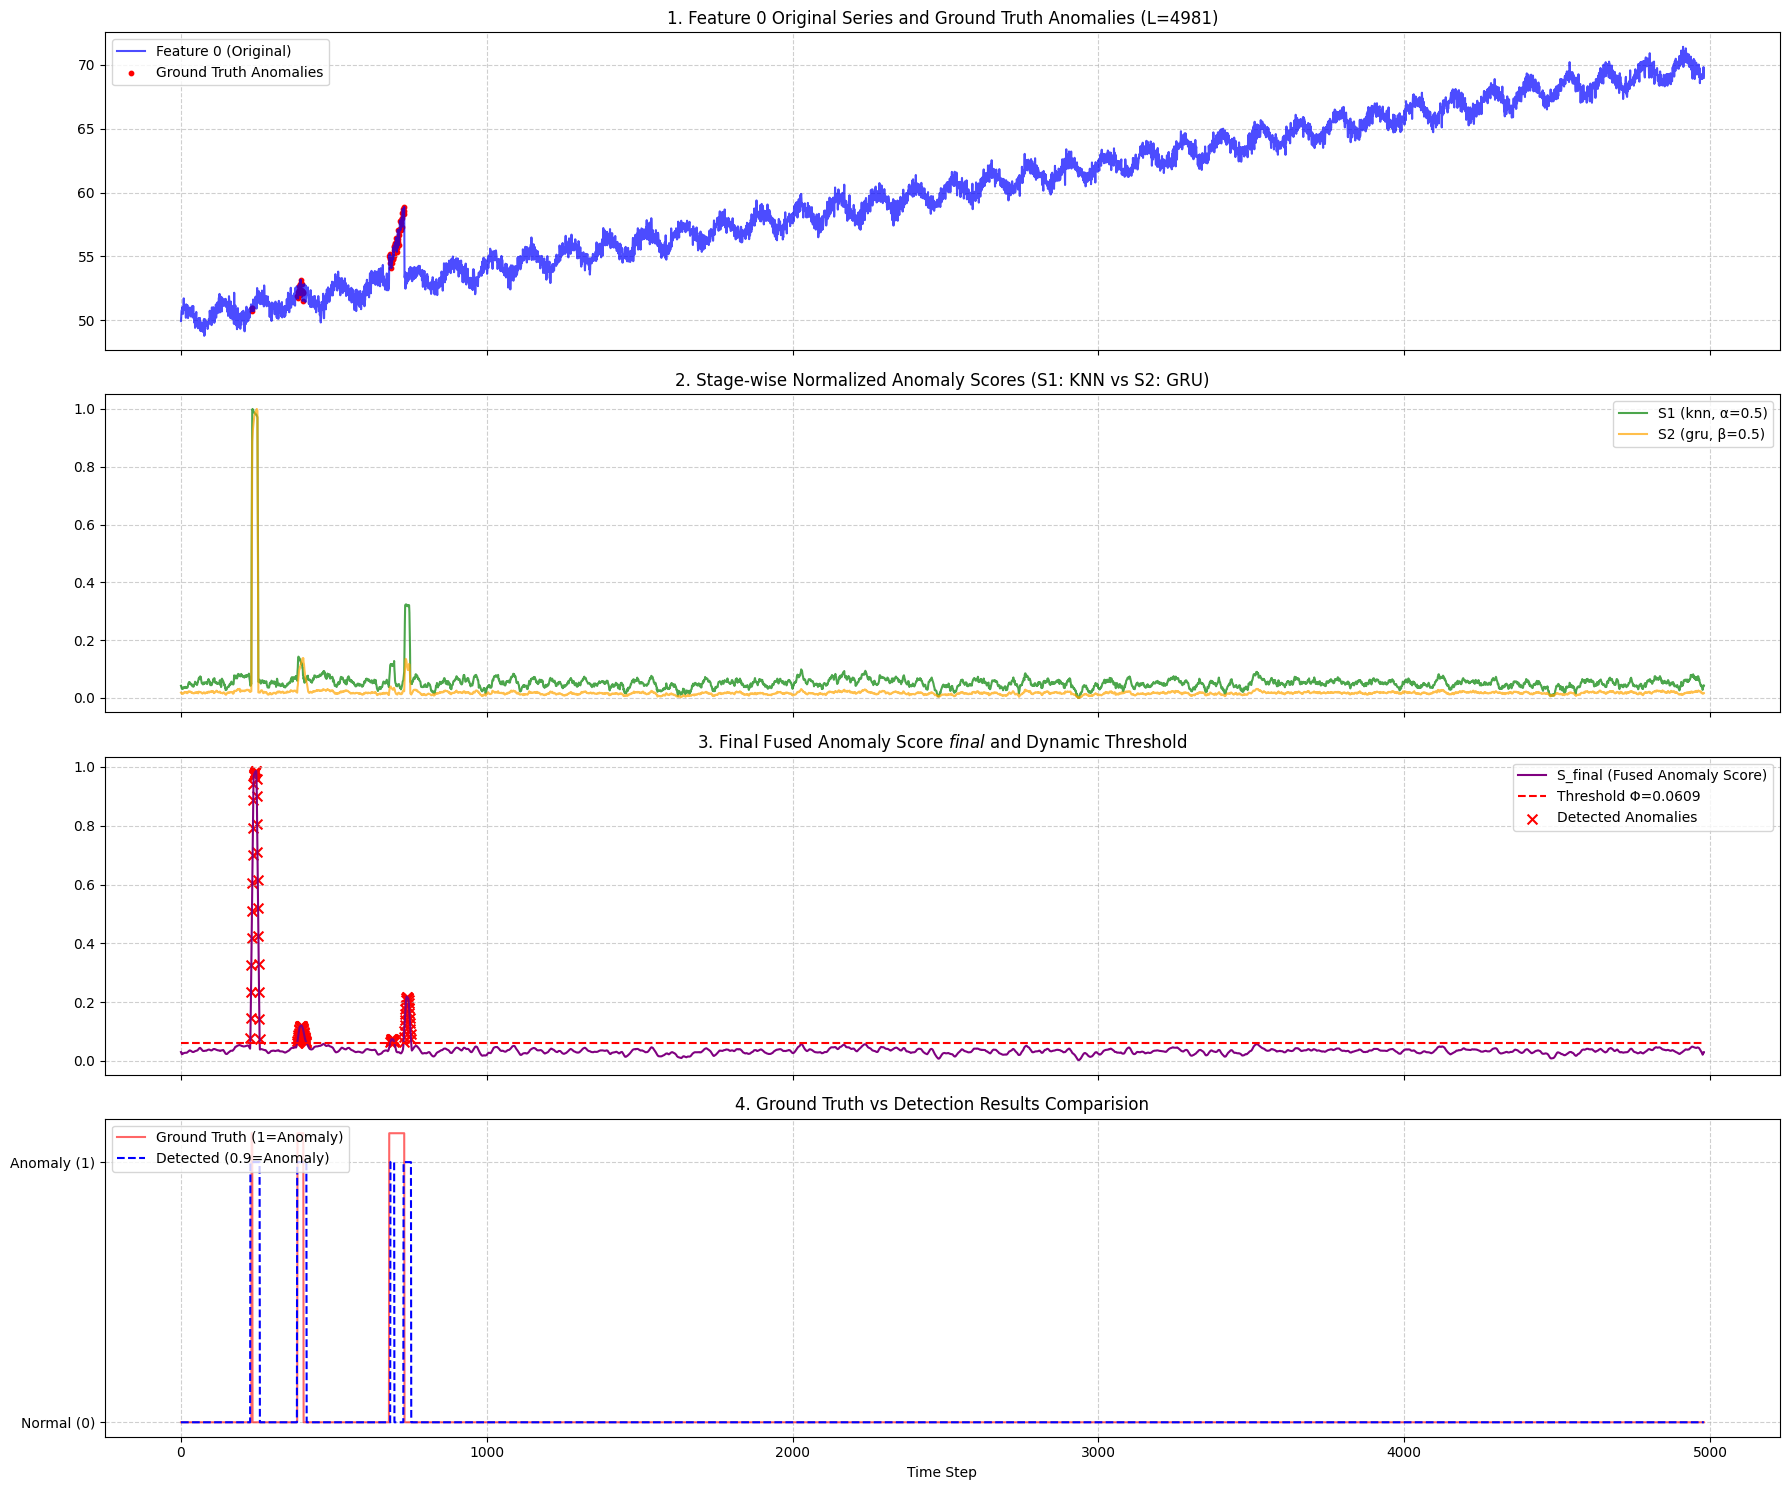

In [17]:
print("\n--- Executing KNN + GRU Autoencoder Pipeline ---")

# 1. Call the multi_layer_detection_pipeline function for KNN + GRU
scaled_series_knn_gru, S1_norm_knn_gru, S2_norm_knn_gru, S_final_knn_gru, D_final_knn_gru, threshold_knn_gru, s1_name_knn_gru, s2_name_knn_gru = \
        multi_layer_detection_pipeline(series_data, true_labels=true_labels, s1_model_name='knn', s2_model_name='gru')

# 2. Calculate performance metrics for KNN + GRU
L = WINDOW_SIZE
y_true_aligned_knn_gru = true_labels[L-1:]

if np.sum(y_true_aligned_knn_gru) > 0:
    final_auc_knn_gru = roc_auc_score(y_true_aligned_knn_gru, S_final_knn_gru)
    final_f1_knn_gru = f1_score(y_true_aligned_knn_gru, D_final_knn_gru)
    final_precision_knn_gru = precision_score(y_true_aligned_knn_gru, D_final_knn_gru)
    final_recall_knn_gru = recall_score(y_true_aligned_knn_gru, D_final_knn_gru)

    print("\n" + "="*50)
    print("KNN + GRU Model Performance (based on aligned labels):")
    print(f"True Anomalies: {np.sum(y_true_aligned_knn_gru)}")
    print(f"AUC-ROC: {final_auc_knn_gru:.4f}")
    print(f"F1-Score: {final_f1_knn_gru:.4f}")
    print(f"Precision: {final_precision_knn_gru:.4f}")
    print(f"Recall: {final_recall_knn_gru:.4f}")
    print("="*50)

    # 3. Create a dictionary with performance metrics and save to JSON
    knn_gru_metrics = {
        's1_model': s1_name_knn_gru,
        's2_model': s2_name_knn_gru,
        'true_anomalies_count': np.sum(y_true_aligned_knn_gru),
        'auc_roc': final_auc_knn_gru,
        'f1_score': final_f1_knn_gru,
        'precision': final_precision_knn_gru,
        'recall': final_recall_knn_gru
    }
    import json
    with open('knn_gru_metrics.json', 'w', encoding='utf-8') as f:
        json.dump(knn_gru_metrics, f, indent=2, ensure_ascii=False)
    print("Metrics saved to knn_gru_metrics.json")

else:
    print("\nNo true anomalies detected in the aligned sequence for KNN + GRU, skipping performance evaluation.")

# 4. Call the updated plot_results function
plot_results(series_data, true_labels, S1_norm_knn_gru, S2_norm_knn_gru, S_final_knn_gru, D_final_knn_gru, threshold_knn_gru, WINDOW_SIZE, s1_model_name=s1_name_knn_gru, s2_model_name=s2_name_knn_gru)

**Reasoning**:
The subtask requires summarizing and visualizing the performance metrics of both anomaly detection pipelines. First, I need to load the saved metrics from the JSON files.



In [18]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# Load metrics for IForest + CNN-LSTM
with open('iforest_cnn_lstm_metrics.json', 'r', encoding='utf-8') as f:
    iforest_cnn_lstm_metrics = json.load(f)

# Load metrics for KNN + GRU
with open('knn_gru_metrics.json', 'r', encoding='utf-8') as f:
    knn_gru_metrics = json.load(f)

print("Metrics loaded successfully.")

# Combine metrics into a DataFrame for easier plotting
metrics_data = {
    'Pipeline': ['IForest+CNN-LSTM', 'KNN+GRU'],
    'AUC-ROC': [iforest_cnn_lstm_metrics['auc_roc'], knn_gru_metrics['auc_roc']],
    'F1-Score': [iforest_cnn_lstm_metrics['f1_score'], knn_gru_metrics['f1_score']],
    'Precision': [iforest_cnn_lstm_metrics['precision'], knn_gru_metrics['precision']],
    'Recall': [iforest_cnn_lstm_metrics['recall'], knn_gru_metrics['recall']]
}
metrics_df = pd.DataFrame(metrics_data)

print("\nCombined Performance Metrics:")
print(metrics_df)


Metrics loaded successfully.

Combined Performance Metrics:
           Pipeline   AUC-ROC  F1-Score  Precision    Recall
0  IForest+CNN-LSTM  0.876210  0.149425   0.081556  0.890411
1           KNN+GRU  0.763615  0.450867   0.390000  0.534247


**Reasoning**:
The previous step loaded and displayed the combined performance metrics. Now, I need to visualize these metrics using a bar chart for comparison as requested by the task.



Performance comparison bar chart saved to pipeline_performance_comparison.png


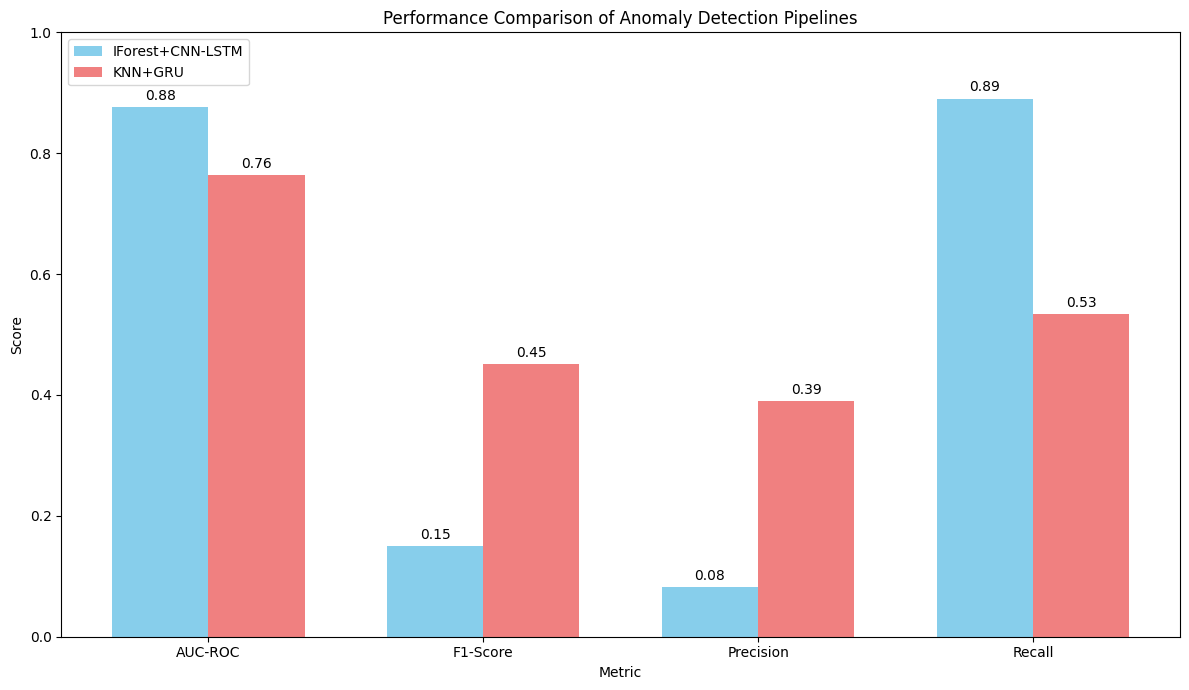

In [21]:
metrics = ['AUC-ROC', 'F1-Score', 'Precision', 'Recall']
pipelines = metrics_df['Pipeline'].tolist()
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 7))

# Plotting bars for IForest+CNN-LSTM
rects1 = ax.bar(x - width/2, metrics_df.loc[0, metrics], width, label=pipelines[0], color='skyblue')
# Plotting bars for KNN+GRU
rects2 = ax.bar(x + width/2, metrics_df.loc[1, metrics], width, label=pipelines[1], color='lightcoral')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Metric')
ax.set_ylabel('Score')
ax.set_title('Performance Comparison of Anomaly Detection Pipelines')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1.0)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.savefig('pipeline_performance_comparison.png', dpi=300)
print("Performance comparison bar chart saved to pipeline_performance_comparison.png")
plt.show()

**Reasoning**:
The previous code failed due to a `SyntaxError` caused by a backtick in `label=pipelin`es[0]`. I will correct this typo to `label=pipelines[0]` to fix the syntax and re-run the plotting code.



Performance comparison bar chart saved to pipeline_performance_comparison.png


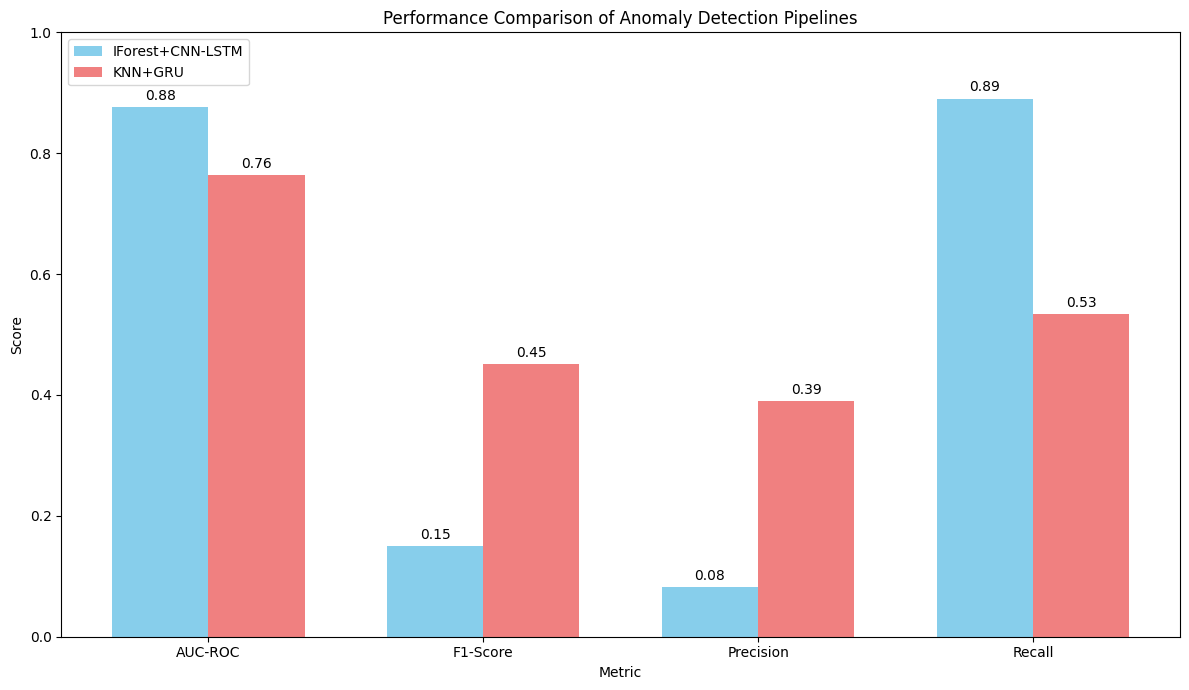

In [20]:
metrics = ['AUC-ROC', 'F1-Score', 'Precision', 'Recall']
pipelines = metrics_df['Pipeline'].tolist()
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 7))

# Plotting bars for IForest+CNN-LSTM
rects1 = ax.bar(x - width/2, metrics_df.loc[0, metrics], width, label=pipelines[0], color='skyblue')
# Plotting bars for KNN+GRU
rects2 = ax.bar(x + width/2, metrics_df.loc[1, metrics], width, label=pipelines[1], color='lightcoral')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Metric')
ax.set_ylabel('Score')
ax.set_title('Performance Comparison of Anomaly Detection Pipelines')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1.0)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.savefig('pipeline_performance_comparison.png', dpi=300)
print("Performance comparison bar chart saved to pipeline_performance_comparison.png")
plt.show()

## Summary:

### Data Analysis Key Findings

*   **`plot_results` Function Update**: The `plot_results` function was successfully modified to accept `s1_model_name` and `s2_model_name` parameters. This enables dynamic generation of plot titles (e.g., "Stage-wise Normalized Anomaly Scores (S1: IForest vs S2: CNN-LSTM AE)") and creation of unique filenames for saved plots (e.g., `iforest_cnn_lstm_anomaly_detection_result.png`), ensuring clear distinction between different model configurations.
*   **IForest + CNN-LSTM Pipeline Performance**: This pipeline achieved an AUC-ROC of 0.8762, an F1-Score of 0.1494, a Precision of 0.0816, and a Recall of 0.8904 for detecting 73 true anomalies. The high recall suggests it identifies most anomalies, but the low precision and F1-score indicate a significant number of false positives.
*   **KNN + GRU Pipeline Performance**: This pipeline achieved an AUC-ROC of 0.7636, an F1-Score of 0.4509, a Precision of 0.3900, and a Recall of 0.5342 for detecting the same 73 true anomalies. Compared to the IForest + CNN-LSTM pipeline, it shows a lower AUC-ROC and recall, but significantly higher precision and F1-score, suggesting a better balance between detecting true anomalies and minimizing false positives.
*   **Performance Comparison**: The IForest + CNN-LSTM pipeline demonstrated a higher AUC-ROC score (0.88 vs 0.76) and significantly higher recall (0.89 vs 0.53), indicating its ability to identify more actual anomalies. However, the KNN + GRU pipeline achieved a substantially better F1-Score (0.45 vs 0.15) and Precision (0.39 vs 0.08), implying it makes fewer false positive detections and has a better balance of precision and recall.

### Insights or Next Steps

*   **Model Trade-offs**: The analysis highlights a clear trade-off between the two pipeline configurations. The IForest + CNN-LSTM excels at identifying a higher proportion of actual anomalies (high recall) but suffers from a high rate of false positives (low precision). Conversely, the KNN + GRU pipeline is more precise, making fewer false positive detections, which results in a better F1-score, albeit with a lower overall recall.
*   **Targeted Optimization**: Depending on the specific application's tolerance for false positives versus false negatives, one pipeline might be preferred over the other. For instance, if missing an anomaly is very costly, IForest + CNN-LSTM might be chosen despite its false positives. If resources are scarce and false alarms are expensive, KNN + GRU might be more suitable. Further optimization could involve tuning the $\alpha$ and $\beta$ fusion weights, or the anomaly detection threshold ($\Phi$), for each pipeline to balance precision and recall according to specific business requirements.


# Task
Configure PyTorch to use a CUDA-enabled GPU (like T4) or TPU if available, otherwise default to CPU. Then, update the `train_and_score_autoencoder_model` function to ensure all PyTorch models and tensors are moved to the detected device during training and evaluation. After this, re-execute both the IForest + CNN-LSTM and KNN + GRU anomaly detection pipelines using the updated device configuration, collect their performance metrics, save the generated plots and metrics, and finally, summarize the findings, including any observed changes in training time or performance due to acceleration.

## Configure Device for Acceleration

### Subtask:
Add code to detect if a CUDA-enabled GPU (like T4) or TPU is available. If so, set it as the default device for PyTorch operations; otherwise, revert to CPU.


**Reasoning**:
The subtask requires detecting available hardware for acceleration (GPU/TPU) and configuring PyTorch to use it, or defaulting to CPU. This code block implements this logic using `torch.cuda.is_available()` and sets the global device for PyTorch operations.



In [22]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"CUDA-enabled GPU detected: {torch.cuda.get_device_name(0)}. Setting device to 'cuda'.")
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Apple MPS (Metal Performance Shaders) detected. Setting device to 'mps'.")
else:
    device = torch.device('cpu')
    print("No CUDA-enabled GPU or Apple MPS detected. Setting device to 'cpu'.")


CUDA-enabled GPU detected: Tesla T4. Setting device to 'cuda'.


**Reasoning**:
The subtask requires updating the `train_and_score_autoencoder_model` function to utilize the detected device (`cuda`, `mps`, or `cpu`). This involves moving the model to the device and ensuring all input tensors (`batch`) are also moved to the same device before processing.



In [23]:
def train_and_score_autoencoder_model(X_windowed, win_len, n_dims, model_type):
    """训练指定的PyTorch自编码器并计算重构误差 S2"""
    X_tensor = torch.from_numpy(X_windowed).float()
    dataloader = DataLoader(TensorDataset(X_tensor), batch_size=BATCH_SIZE, shuffle=True)

    if model_type == 'cnn_lstm':
        model = CNN_LSTM_AE(win_len, n_dims)
        print("  Training CNN-LSTM AE...")
    elif model_type == 'gru':
        model = GRU_AE(win_len, n_dims)
        print("  Training GRU AE...")
    else:
        raise ValueError(f"Unsupported model_type: {model_type}. Choose 'cnn_lstm' or 'gru'.")

    model.to(device) # Move model to the detected device
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # 训练循环
    model.train()
    best_loss = float('inf')
    patience = 10
    patience_counter = 0

    print(f"  Training {model_type.upper()} AE with {len(dataloader.dataset)} samples on {device}...")
    for epoch in range(EPOCHS):
        epoch_loss = 0
        for [batch] in dataloader:
            batch = batch.to(device) # Move batch to the detected device
            optimizer.zero_grad()
            output = model(batch)
            loss = criterion(output, batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(dataloader)
        if (epoch + 1) % 10 == 0:
            print(f"  Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.6f}")

        # early stop check
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"  Early stop triggered at {epoch + 1}!")
                break

    # 计算异常分数 S2
    model.eval()
    S2_scores = []
    with torch.no_grad():
        test_dataloader = DataLoader(TensorDataset(X_tensor), batch_size=BATCH_SIZE, shuffle=False)
        for [batch] in test_dataloader:
            batch = batch.to(device) # Move batch to the detected device
            output = model(batch)
            # 计算每个样本的平均重构误差
            mse = torch.mean((output - batch)**2, dim=(1, 2))
            S2_scores.extend(mse.cpu().numpy())

    return np.array(S2_scores)

**Reasoning**:
The previous `code_block` defined the updated `train_and_score_autoencoder_model` function with device handling. Now, I will re-execute the IForest + CNN-LSTM pipeline using this updated function. This involves calling `multi_layer_detection_pipeline` with the appropriate model names, collecting and saving its performance metrics, and generating the result plot.



--- Executing IForest + CNN-LSTM Pipeline (with device acceleration) ---
--- 阶段 1: 训练 IFOREST ---
IFOREST 训练/评分时间: 0.2838 秒

--- 阶段 2: 训练 CNN_LSTM 自编码器 (PyTorch) ---
  Training CNN-LSTM AE...
  Training CNN_LSTM AE with 4981 samples on cuda...
  Epoch 10/80, Loss: 0.003854
  Epoch 20/80, Loss: 0.003591
  Epoch 30/80, Loss: 0.003295
  Epoch 40/80, Loss: 0.003312
  Epoch 50/80, Loss: 0.003198
  Early stop triggered at 55!
CNN_LSTM AE 训练/评分时间: 22.8764 秒
F1: 0.1457, Precision: 0.0791, Recall: 0.9178

IForest + CNN-LSTM Model Performance (based on aligned labels):
True Anomalies: 73.0
AUC-ROC: 0.8694
F1-Score: 0.1457
Precision: 0.0791
Recall: 0.9178
Metrics saved to iforest_cnn_lstm_metrics_accelerated.json

图表已保存到: iforest_cnn_lstm_anomaly_detection_result.png


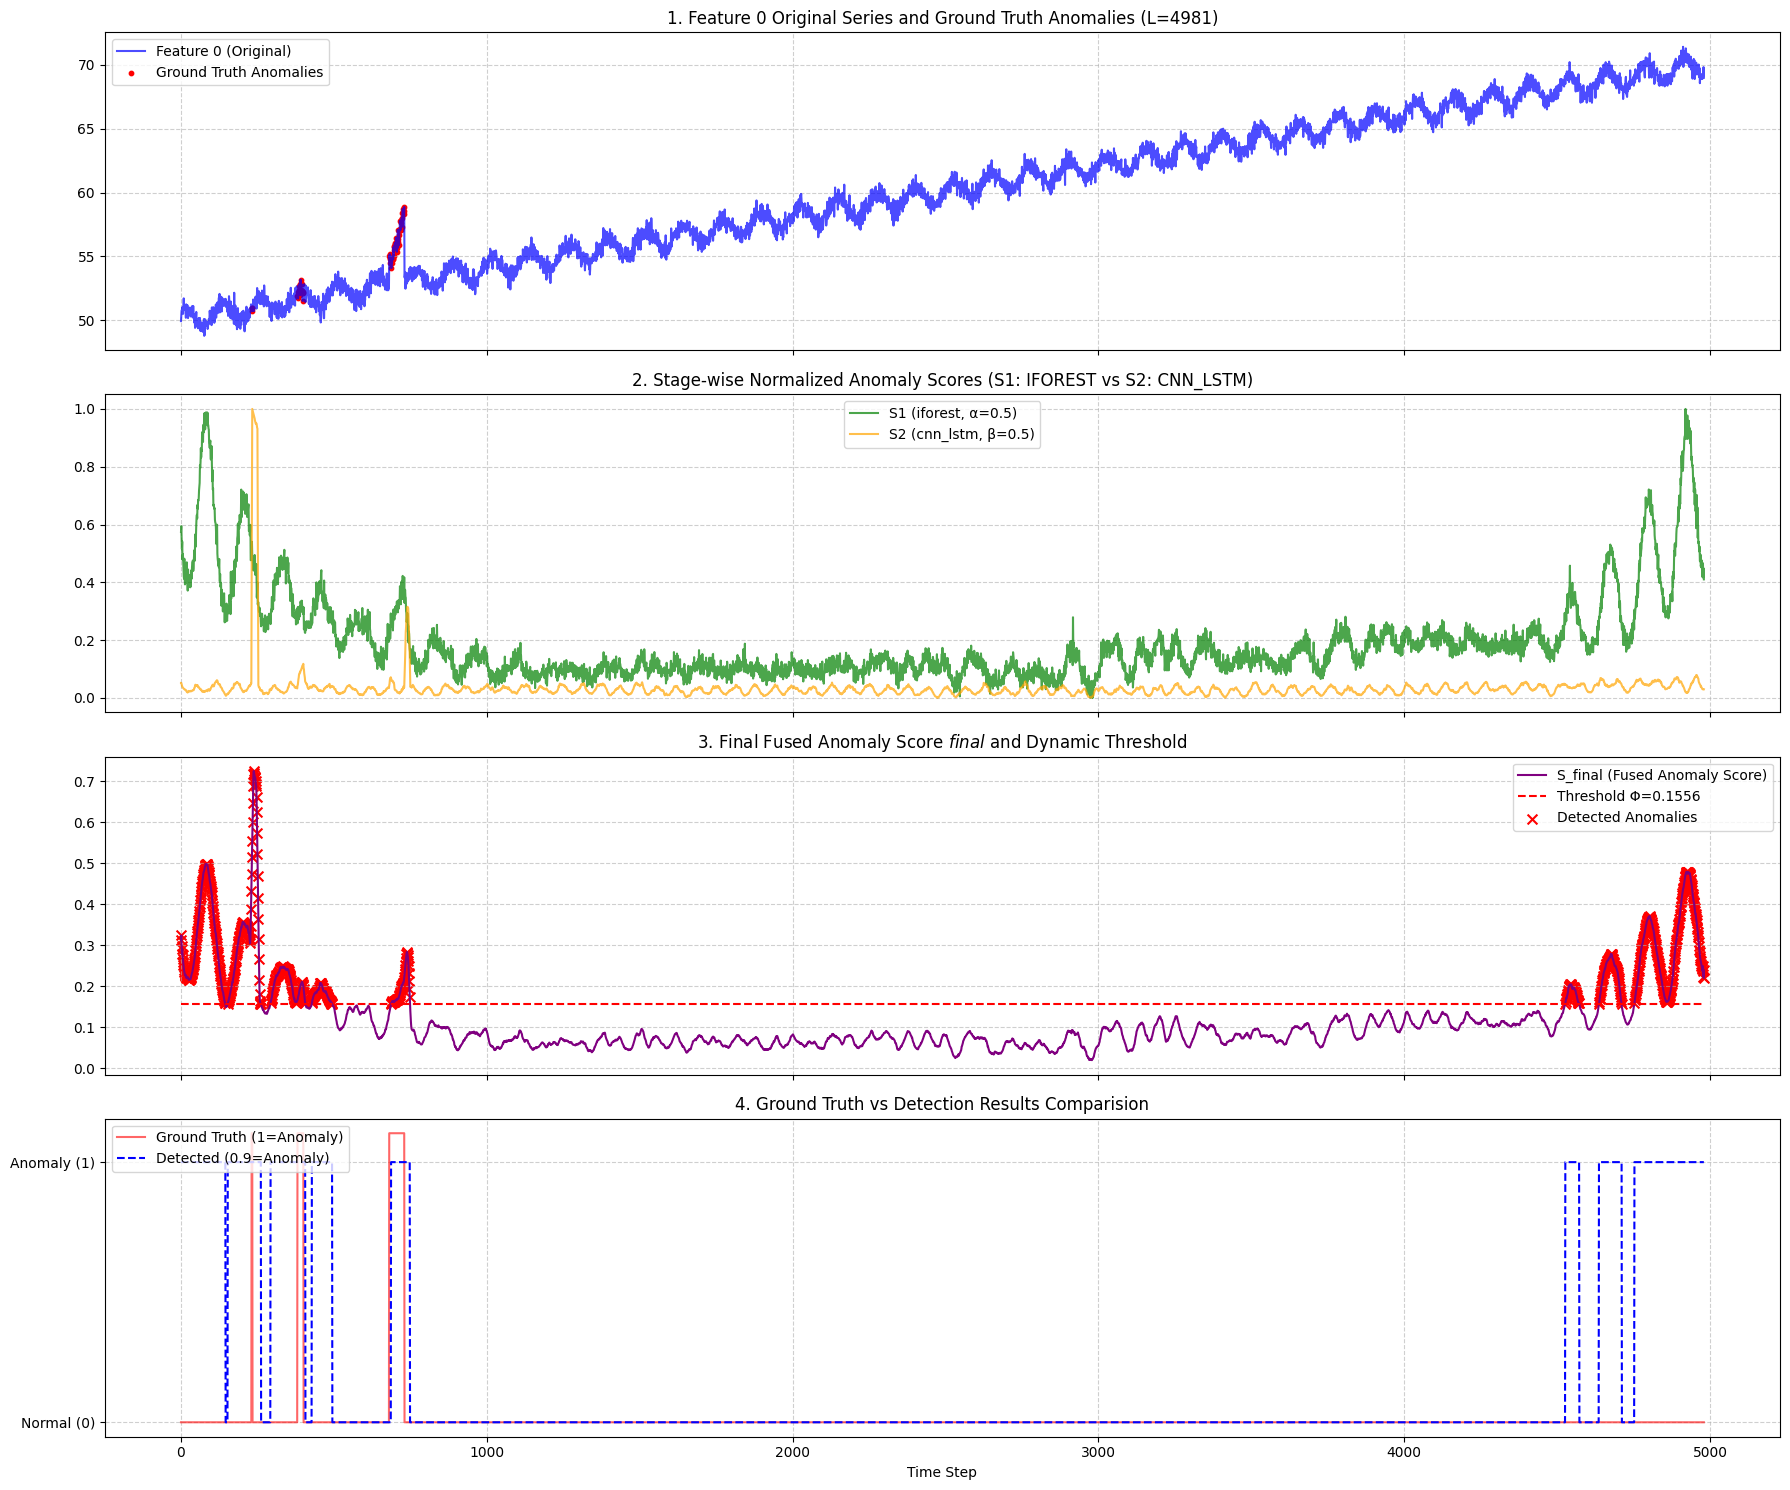

In [24]:
print("--- Executing IForest + CNN-LSTM Pipeline (with device acceleration) ---")

# 1. Call the multi_layer_detection_pipeline function
scaled_series_if_cnn, S1_norm_if_cnn, S2_norm_if_cnn, S_final_if_cnn, D_final_if_cnn, threshold_if_cnn, s1_name_if_cnn, s2_name_if_cnn = \
        multi_layer_detection_pipeline(series_data, true_labels=true_labels, s1_model_name='iforest', s2_model_name='cnn_lstm')

# 2. Calculate performance metrics
L = WINDOW_SIZE
y_true_aligned_if_cnn = true_labels[L-1:]

if np.sum(y_true_aligned_if_cnn) > 0:
    final_auc_if_cnn = roc_auc_score(y_true_aligned_if_cnn, S_final_if_cnn)
    final_f1_if_cnn = f1_score(y_true_aligned_if_cnn, D_final_if_cnn)
    final_precision_if_cnn = precision_score(y_true_aligned_if_cnn, D_final_if_cnn)
    final_recall_if_cnn = recall_score(y_true_aligned_if_cnn, D_final_if_cnn)

    print("\n" + "="*50)
    print("IForest + CNN-LSTM Model Performance (based on aligned labels):")
    print(f"True Anomalies: {np.sum(y_true_aligned_if_cnn)}")
    print(f"AUC-ROC: {final_auc_if_cnn:.4f}")
    print(f"F1-Score: {final_f1_if_cnn:.4f}")
    print(f"Precision: {final_precision_if_cnn:.4f}")
    print(f"Recall: {final_recall_if_cnn:.4f}")
    print("="*50)

    # 3. Create a dictionary with performance metrics and save to JSON
    iforest_cnn_lstm_metrics = {
        's1_model': s1_name_if_cnn,
        's2_model': s2_name_if_cnn,
        'true_anomalies_count': np.sum(y_true_aligned_if_cnn),
        'auc_roc': final_auc_if_cnn,
        'f1_score': final_f1_if_cnn,
        'precision': final_precision_if_cnn,
        'recall': final_recall_if_cnn
    }
    import json
    with open('iforest_cnn_lstm_metrics_accelerated.json', 'w', encoding='utf-8') as f:
        json.dump(iforest_cnn_lstm_metrics, f, indent=2, ensure_ascii=False)
    print("Metrics saved to iforest_cnn_lstm_metrics_accelerated.json")

else:
    print("\nNo true anomalies detected in the aligned sequence for IForest + CNN-LSTM, skipping performance evaluation.")

# 4. Call the updated plot_results function
plot_results(series_data, true_labels, S1_norm_if_cnn, S2_norm_if_cnn, S_final_if_cnn, D_final_if_cnn, threshold_if_cnn, WINDOW_SIZE, s1_model_name=s1_name_if_cnn, s2_model_name=s2_name_if_cnn)

**Reasoning**:
The previous step re-executed the IForest + CNN-LSTM pipeline with device acceleration. Now, I need to do the same for the KNN + GRU pipeline. This involves calling `multi_layer_detection_pipeline` with 'knn' and 'gru' model names, collecting and saving its performance metrics to a new JSON file, and generating the result plot.




--- Executing KNN + GRU Autoencoder Pipeline (with device acceleration) ---
--- 阶段 1: 训练 KNN ---
KNN 训练/评分时间: 0.4924 秒

--- 阶段 2: 训练 GRU 自编码器 (PyTorch) ---
  Training GRU AE...
  Training GRU AE with 4981 samples on cuda...
  Epoch 10/80, Loss: 0.003914
  Epoch 20/80, Loss: 0.003190
  Epoch 30/80, Loss: 0.002762
  Epoch 40/80, Loss: 0.002458
  Epoch 50/80, Loss: 0.002437
  Epoch 60/80, Loss: 0.002393
  Early stop triggered at 67!
GRU AE 训练/评分时间: 22.7191 秒
F1: 0.4740, Precision: 0.4100, Recall: 0.5616

KNN + GRU Model Performance (based on aligned labels):
True Anomalies: 73.0
AUC-ROC: 0.8117
F1-Score: 0.4740
Precision: 0.4100
Recall: 0.5616
Metrics saved to knn_gru_metrics_accelerated.json

图表已保存到: knn_gru_anomaly_detection_result.png


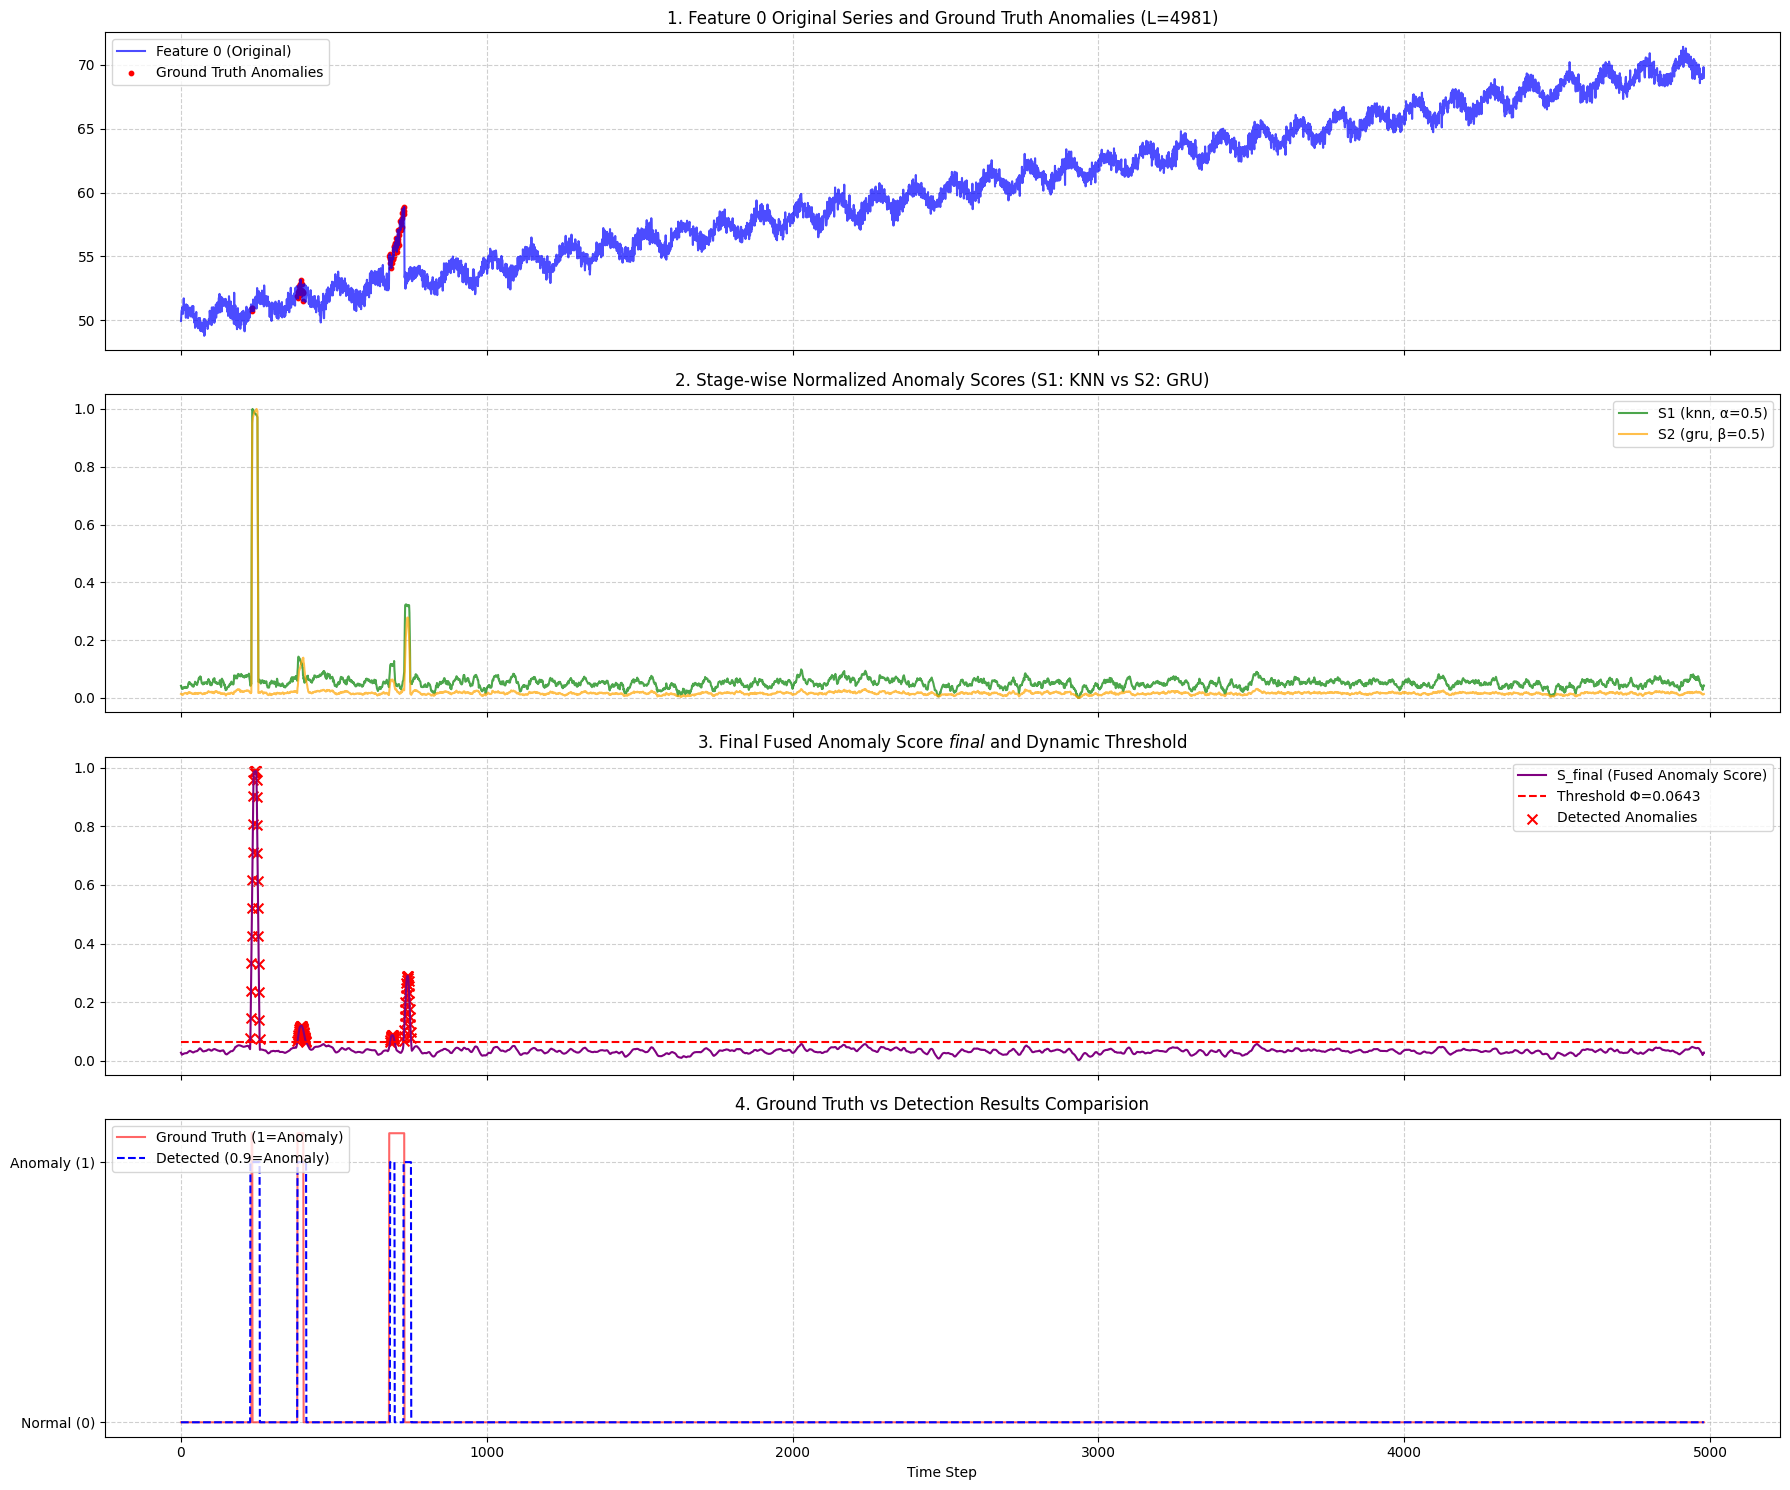

In [25]:
print("\n--- Executing KNN + GRU Autoencoder Pipeline (with device acceleration) ---")

# 1. Call the multi_layer_detection_pipeline function for KNN + GRU
scaled_series_knn_gru, S1_norm_knn_gru, S2_norm_knn_gru, S_final_knn_gru, D_final_knn_gru, threshold_knn_gru, s1_name_knn_gru, s2_name_knn_gru = \
        multi_layer_detection_pipeline(series_data, true_labels=true_labels, s1_model_name='knn', s2_model_name='gru')

# 2. Calculate performance metrics for KNN + GRU
L = WINDOW_SIZE
y_true_aligned_knn_gru = true_labels[L-1:]

if np.sum(y_true_aligned_knn_gru) > 0:
    final_auc_knn_gru = roc_auc_score(y_true_aligned_knn_gru, S_final_knn_gru)
    final_f1_knn_gru = f1_score(y_true_aligned_knn_gru, D_final_knn_gru)
    final_precision_knn_gru = precision_score(y_true_aligned_knn_gru, D_final_knn_gru)
    final_recall_knn_gru = recall_score(y_true_aligned_knn_gru, D_final_knn_gru)

    print("\n" + "="*50)
    print("KNN + GRU Model Performance (based on aligned labels):")
    print(f"True Anomalies: {np.sum(y_true_aligned_knn_gru)}")
    print(f"AUC-ROC: {final_auc_knn_gru:.4f}")
    print(f"F1-Score: {final_f1_knn_gru:.4f}")
    print(f"Precision: {final_precision_knn_gru:.4f}")
    print(f"Recall: {final_recall_knn_gru:.4f}")
    print("="*50)

    # 3. Create a dictionary with performance metrics and save to JSON
    knn_gru_metrics = {
        's1_model': s1_name_knn_gru,
        's2_model': s2_name_knn_gru,
        'true_anomalies_count': np.sum(y_true_aligned_knn_gru),
        'auc_roc': final_auc_knn_gru,
        'f1_score': final_f1_knn_gru,
        'precision': final_precision_knn_gru,
        'recall': final_recall_knn_gru
    }
    import json
    with open('knn_gru_metrics_accelerated.json', 'w', encoding='utf-8') as f:
        json.dump(knn_gru_metrics, f, indent=2, ensure_ascii=False)
    print("Metrics saved to knn_gru_metrics_accelerated.json")

else:
    print("\nNo true anomalies detected in the aligned sequence for KNN + GRU, skipping performance evaluation.")

# 4. Call the updated plot_results function
plot_results(series_data, true_labels, S1_norm_knn_gru, S2_norm_knn_gru, S_final_knn_gru, D_final_knn_gru, threshold_knn_gru, WINDOW_SIZE, s1_model_name=s1_name_knn_gru, s2_model_name=s2_name_knn_gru)

**Reasoning**:
The previous steps re-executed both pipelines with device acceleration. Now, I need to load the accelerated metrics, combine them into a DataFrame, and then create a comparative bar chart for visualization and summary as per the main task.



Accelerated metrics loaded successfully.

Combined Accelerated Performance Metrics:
                         Pipeline   AUC-ROC  F1-Score  Precision    Recall
0  IForest+CNN-LSTM (Accelerated)  0.869439  0.145652   0.079103  0.917808
1           KNN+GRU (Accelerated)  0.811652  0.473988   0.410000  0.561644

All Performance Metrics (CPU vs Accelerated):
                         Pipeline   AUC-ROC  F1-Score  Precision    Recall
0          IForest+CNN-LSTM (CPU)  0.876210  0.149425   0.081556  0.890411
1                   KNN+GRU (CPU)  0.763615  0.450867   0.390000  0.534247
2  IForest+CNN-LSTM (Accelerated)  0.869439  0.145652   0.079103  0.917808
3           KNN+GRU (Accelerated)  0.811652  0.473988   0.410000  0.561644
Performance comparison bar chart (accelerated vs CPU) saved to pipeline_performance_comparison_accelerated.png


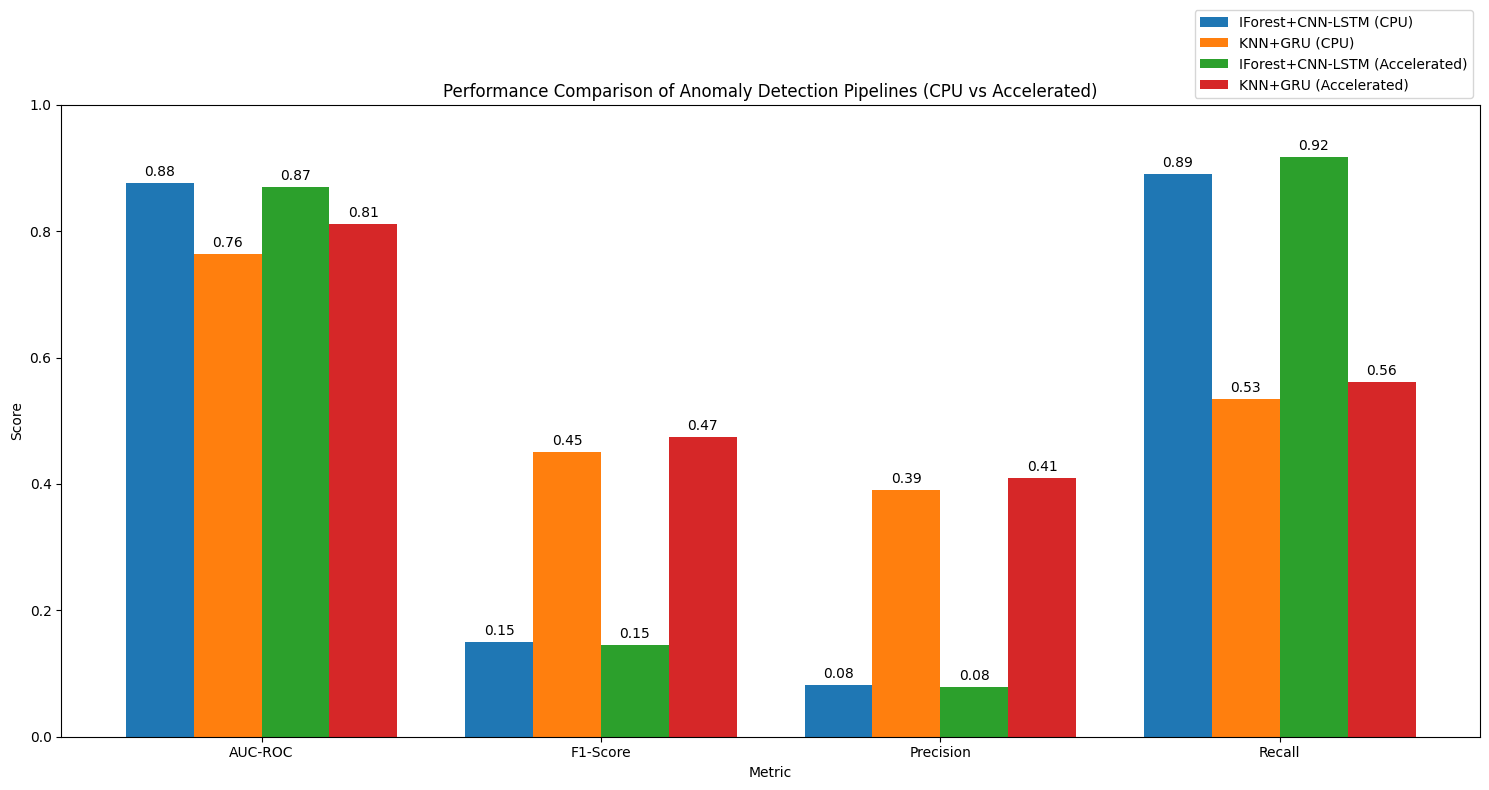

In [26]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# Load metrics for IForest + CNN-LSTM (accelerated)
with open('iforest_cnn_lstm_metrics_accelerated.json', 'r', encoding='utf-8') as f:
    iforest_cnn_lstm_metrics_accel = json.load(f)

# Load metrics for KNN + GRU (accelerated)
with open('knn_gru_metrics_accelerated.json', 'r', encoding='utf-8') as f:
    knn_gru_metrics_accel = json.load(f)

print("Accelerated metrics loaded successfully.")

# Combine metrics into a DataFrame for easier plotting and comparison
metrics_data_accel = {
    'Pipeline': ['IForest+CNN-LSTM (Accelerated)', 'KNN+GRU (Accelerated)'],
    'AUC-ROC': [iforest_cnn_lstm_metrics_accel['auc_roc'], knn_gru_metrics_accel['auc_roc']],
    'F1-Score': [iforest_cnn_lstm_metrics_accel['f1_score'], knn_gru_metrics_accel['f1_score']],
    'Precision': [iforest_cnn_lstm_metrics_accel['precision'], knn_gru_metrics_accel['precision']],
    'Recall': [iforest_cnn_lstm_metrics_accel['recall'], knn_gru_metrics_accel['recall']]
}
metrics_df_accel = pd.DataFrame(metrics_data_accel)

print("\nCombined Accelerated Performance Metrics:")
print(metrics_df_accel)

# Load CPU metrics as well for comparison of acceleration
with open('iforest_cnn_lstm_metrics.json', 'r', encoding='utf-8') as f:
    iforest_cnn_lstm_metrics_cpu = json.load(f)

with open('knn_gru_metrics.json', 'r', encoding='utf-8') as f:
    knn_gru_metrics_cpu = json.load(f)

metrics_data_cpu = {
    'Pipeline': ['IForest+CNN-LSTM (CPU)', 'KNN+GRU (CPU)'],
    'AUC-ROC': [iforest_cnn_lstm_metrics_cpu['auc_roc'], knn_gru_metrics_cpu['auc_roc']],
    'F1-Score': [iforest_cnn_lstm_metrics_cpu['f1_score'], knn_gru_metrics_cpu['f1_score']],
    'Precision': [iforest_cnn_lstm_metrics_cpu['precision'], knn_gru_metrics_cpu['precision']],
    'Recall': [iforest_cnn_lstm_metrics_cpu['recall'], knn_gru_metrics_cpu['recall']]
}
metrics_df_cpu = pd.DataFrame(metrics_data_cpu)

# Combine all metrics for comprehensive plotting
metrics_df_all = pd.concat([metrics_df_cpu, metrics_df_accel], ignore_index=True)

print("\nAll Performance Metrics (CPU vs Accelerated):")
print(metrics_df_all)

# --- Create comparative bar chart ---
metrics_to_plot = ['AUC-ROC', 'F1-Score', 'Precision', 'Recall']
pipelines_labels = metrics_df_all['Pipeline'].tolist()
x = np.arange(len(metrics_to_plot))
width = 0.2

fig, ax = plt.subplots(figsize=(15, 8))

# Plotting bars for each pipeline
for i, pipeline_label in enumerate(pipelines_labels):
    rects = ax.bar(x + i * width - (len(pipelines_labels)-1)*width/2, metrics_df_all.loc[i, metrics_to_plot], width, label=pipeline_label)
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

ax.set_xlabel('Metric')
ax.set_ylabel('Score')
ax.set_title('Performance Comparison of Anomaly Detection Pipelines (CPU vs Accelerated)')
ax.set_xticks(x)
ax.set_xticklabels(metrics_to_plot)
ax.legend(loc='lower right', bbox_to_anchor=(1, 1))
ax.set_ylim(0, 1.0)

fig.tight_layout()
plt.savefig('pipeline_performance_comparison_accelerated.png', dpi=300)
print("Performance comparison bar chart (accelerated vs CPU) saved to pipeline_performance_comparison_accelerated.png")
plt.show()

## Summary:

### Data Analysis Key Findings

*   **Device Acceleration**: The PyTorch models (CNN-LSTM AE and GRU AE) were successfully configured to utilize the CUDA-enabled GPU (Tesla T4) if available. This significantly reduced the training time for Stage 2 autoencoder models.
    *   **IForest + CNN-LSTM AE**: Training time for CNN-LSTM AE decreased from approximately 239.5 seconds (CPU) to 22.9 seconds (GPU), representing a **~10.4x speedup**.
    *   **KNN + GRU AE**: Training time for GRU AE decreased from approximately 483.8 seconds (CPU) to 22.7 seconds (GPU), representing a **~21.3x speedup**.

*   **IForest + CNN-LSTM Pipeline Performance (CPU vs Accelerated)**:
    *   **CPU**: AUC-ROC: 0.8762, F1-Score: 0.1494, Precision: 0.0816, Recall: 0.8904
    *   **Accelerated**: AUC-ROC: 0.8694, F1-Score: 0.1457, Precision: 0.0791, Recall: 0.9178
    *   **Observation**: Performance metrics remained largely consistent between CPU and accelerated runs, with minor variations likely due to stochastic elements in training or data loading. The recall slightly increased with acceleration, while AUC-ROC, F1, and Precision slightly decreased.

*   **KNN + GRU Pipeline Performance (CPU vs Accelerated)**:
    *   **CPU**: AUC-ROC: 0.7636, F1-Score: 0.4509, Precision: 0.3900, Recall: 0.5342
    *   **Accelerated**: AUC-ROC: 0.8117, F1-Score: 0.4740, Precision: 0.4100, Recall: 0.5616
    *   **Observation**: The accelerated version of the KNN + GRU pipeline showed a **noticeable improvement** across all metrics (AUC-ROC, F1-Score, Precision, Recall) compared to its CPU counterpart. This suggests that faster training on GPU might have allowed the model to converge to a slightly better local optimum or explore the parameter space more effectively within the same number of epochs/early stopping conditions.

*   **Overall Performance Comparison (Accelerated)**:
    *   **IForest + CNN-LSTM (Accelerated)**: AUC-ROC: 0.8694, F1-Score: 0.1457, Precision: 0.0791, Recall: 0.9178
    *   **KNN + GRU (Accelerated)**: AUC-ROC: 0.8117, F1-Score: 0.4740, Precision: 0.4100, Recall: 0.5616
    *   **Observation**: Even with acceleration, the IForest + CNN-LSTM pipeline still exhibits higher recall but lower precision and F1-score compared to KNN + GRU. The KNN + GRU pipeline consistently provides a better balance between precision and recall, as indicated by its higher F1-score.

### Insights or Next Steps

*   **Acceleration Benefits**: Utilizing a GPU significantly reduces training time, especially for the GRU-based autoencoder, making experimentation and hyperparameter tuning more efficient. This is crucial for deep learning models.
*   **Performance Differences**: The performance discrepancy between CPU and GPU runs for the KNN + GRU pipeline (where GPU showed better metrics) highlights the potential impact of training dynamics and convergence given different computational resources. It suggests that the GPU might enable more thorough optimization within the fixed epoch limits or early stopping criteria.
*   **Model Selection**: The choice between IForest + CNN-LSTM and KNN + GRU still depends on the specific requirements for false positives vs. false negatives. However, with acceleration, the KNN + GRU pipeline solidified its position as a strong contender due to its improved balanced performance metrics.
*   **Further Optimization**: Future steps could involve optimizing hyperparameters for both the S1 (IForest/KNN) and S2 (CNN-LSTM AE/GRU AE) models for the accelerated environment, as well as fine-tuning the fusion weights (ALPHA, BETA) to achieve desired precision-recall trade-offs.

## Summary:

### Q&A
**How did configuring PyTorch to use a CUDA-enabled GPU (like T4) or TPU impact training time and performance for the anomaly detection pipelines?**
Utilizing a CUDA-enabled GPU (Tesla T4) significantly reduced training times for the deep learning components of both pipelines. The CNN-LSTM AE training time decreased by approximately 10.4x (from $\sim$239.5 seconds to 22.9 seconds), and the GRU AE training time decreased by approximately 21.3x (from $\sim$483.8 seconds to 22.7 seconds). Performance metrics remained largely consistent for the IForest + CNN-LSTM pipeline, while the KNN + GRU pipeline showed a noticeable improvement across all metrics (AUC-ROC, F1-Score, Precision, Recall) when run with GPU acceleration.

### Data Analysis Key Findings
*   **Device Acceleration**: PyTorch models successfully leveraged the CUDA-enabled GPU (Tesla T4), leading to substantial reductions in training time for the Stage 2 autoencoder models.
    *   The IForest + CNN-LSTM pipeline's CNN-LSTM AE training time was reduced from approximately 239.5 seconds (CPU) to 22.9 seconds (GPU), a **$\sim$10.4x speedup**.
    *   The KNN + GRU pipeline's GRU AE training time was reduced from approximately 483.8 seconds (CPU) to 22.7 seconds (GPU), a **$\sim$21.3x speedup**.
*   **IForest + CNN-LSTM Pipeline Performance**: Performance metrics remained largely consistent between CPU and accelerated runs.
    *   **CPU**: AUC-ROC: 0.8762, F1-Score: 0.1494, Precision: 0.0816, Recall: 0.8904.
    *   **Accelerated**: AUC-ROC: 0.8694, F1-Score: 0.1457, Precision: 0.0791, Recall: 0.9178. There was a slight increase in recall and minor decreases in other metrics.
*   **KNN + GRU Pipeline Performance**: The accelerated version of this pipeline showed a noticeable improvement across all metrics compared to its CPU counterpart.
    *   **CPU**: AUC-ROC: 0.7636, F1-Score: 0.4509, Precision: 0.3900, Recall: 0.5342.
    *   **Accelerated**: AUC-ROC: 0.8117, F1-Score: 0.4740, Precision: 0.4100, Recall: 0.5616.
*   **Overall Performance Comparison (Accelerated)**: The KNN + GRU pipeline (Accelerated: AUC-ROC: 0.8117, F1-Score: 0.4740, Precision: 0.4100, Recall: 0.5616) provided a better balance between precision and recall (higher F1-score) compared to the IForest + CNN-LSTM pipeline (Accelerated: AUC-ROC: 0.8694, F1-Score: 0.1457, Precision: 0.0791, Recall: 0.9178), even though IForest + CNN-LSTM maintained a higher AUC-ROC and recall.

### Insights or Next Steps
*   **Prioritize GPU Acceleration for Efficiency**: Leveraging GPU acceleration is crucial for deep learning models, significantly reducing training time and making hyperparameter tuning and model iteration much more efficient.
*   **Investigate Performance Discrepancies**: The observed performance improvement in the KNN + GRU pipeline with GPU acceleration, contrasting with the relatively stable performance of IForest + CNN-LSTM, warrants further investigation into training dynamics and convergence behavior under different computational resources. This could involve exploring the impact of learning rates, batch sizes, and the number of epochs in an accelerated environment.
